# Project: Determining the Most Profitable Oil Production Region

The client provided a dataset of oil samples from three regions. Each region contains 10,000 deposits where the quality of the oil and the volume of its reserves were measured.

**Project Goal:**

Build a machine learning model that will help determine the region where production will bring the greatest profit.

## Загрузка и подготовка данных

### Подключение библиотек

In [12]:
import sys
import platform
import sklearn
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    mean_squared_error
)
import pandas as pd
import numpy
import os

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [14]:
RANDOM_STATE=42

In [15]:
def histnbox_plot_for_feature(df, feature_name):
    '''
    Функция вывода гистограмм и ящика с усами для количесвтенных данных.
    Функция сама определяет все колличественные серии, а затем строит для них графики
    Args:
        df: исходный датасет, по которым необходимо построить графики.
        feature_name: Признак для которго необходимо построить графики
    Return:
        Гистрограмма и бокплот для конкретного признака
    '''
    sns.set_style('whitegrid')
    title         = 'Гистограмма и ящик с усами для: ' + feature_name    
    f, ax         = plt.subplots(1,2, figsize=(16, 8))
    
    f.tight_layout()
    f.set_figheight(10)
    f.set_figwidth(20)
    plt.rcParams.update({'font.size': 10}) 
    
    sns.histplot(data = df[feature_name],                     
                kde  = True, 
                bins = 50, 
                ax   = ax[0])  
        
    sns.boxplot(y = df[feature_name], 
                ax   = ax[1],
                showmeans=True,
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})   
    ###################
    #   Гистограмма
    # Заголовок
    ax[0].set_title('Серия: ' + feature_name + ' . Тип: ' + str(df.dtypes[feature_name]))
    # Подпись по оси x
    ax[0].set_xlabel('Параметр: ' + feature_name)
    # Подпись по оси y
    ax[0].set_ylabel('Количество')
        
    ####################
    #    Ящик с усами
    # Заголовок
    ax[1].set_title('Серия: ' + feature_name)
        
    # Подпись по оси x
    ax[1].set_xlabel('Параметр: ' + feature_name)    
            
    plt.suptitle(title, fontsize=20, y=1.01)
    plt.show()

def plot_corr_heatmap(df, title, method='spearman'):
    ''' Вывод тепловой карты кореляций между числовыми признаками датасет
    
    По умолчанию кореляционный анализ расчитывается по методу Спирмена. Однако если этот метод в не подходит,
    то его можно указать явно, в параметре method.
    
    Корреляция (от лат. correlatio – соотношение). 
        1. Мера степени и направления связи между значениями двух переменных. 
        2. Статистический показатель вероятности связи между двумя переменными, измеренными в количественной шкале
    
    Args:
        df: датасет с числовыми признаками, между которыми требуется расчитать коэф. кореляции и сформировать тепловую карты
        title: Заголовок тепловой карты
        method: Метод расчета кореляции. Может принмать следующие значения:
            pearson : Стандартный коэфициент кореляции
                      (r-Pearson). Мера корреляции, подходящая для непрерывных признаков, измеренных на одной и той же выборке
                      Можно использовать только в том, случае, если признаки имеют **нормальное** распределение. 
            kendall : Коэфициент ранговой кореляции Кендала
            spearman : Коэфициент ранговой кореляции Спирмена
                       (r-Spearman's). Мера корреляции, подходящая для двух переменных, измеренных в ранговой шкале.
                       При расчете анализируются не сами значения признаков, а их взаимное расположение – ранги. 
                       В этом случае признаки, между которыми рассчитывается взаимосвязи, не должны быть распределены 
                       по нормальному закону
    '''
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(15, 15))

    # Set the title and font properties
    plt.title(f'Матрица кореляции датасета {title}', fontweight='bold', y=1.02, size=20)


    # Plot the heatmap with the masked diagonal elements
    ax = sns.heatmap(df.astype(float).corr(method=method), 
                     linewidths=0.1, 
                     vmax=1.0, 
                     vmin=-1.0, 
                     square=True, 
                     cmap=colormap, 
                     linecolor='white', 
                     annot=True, 
                     annot_kws={"size": 10, "weight": "bold"},
                     mask=mask)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
def scaler_viz(X_num):
    ''' Сравнительный визуальный анализ числовых признаков датасета.    
    
    Функция отрисовки двух графиков гистограммы и боксплота
    на которых методом наложения выводятся числовые признаки датасета.
    С помощью данной функции можно увидеть относительный разброс числовых данных
    для того, чтобы принять решение о необходимости проводения масштабирования   
    
    Args:
        X_num: датасет с числовыми признаками, которые будут учавствовать в моделировании    
    Returns:
        Боксплот и Гистограма с числовыми признаками входного датасета
    '''
    
    fig, axes = plt.subplots(nrows= 1, 
                             ncols= 2, 
                             figsize= (10,5))

    X_num.plot(kind= 'hist', 
               bins= 10, 
               ax= axes[0])

    axes[0].set_title('Гистограмма распределения')
    axes[1].set_title('Разброс значений признаков')

    X_num.plot(kind= 'box',   
               ax= axes[1], 
               rot= 45)
    plt.show()

def data_scaler(X_train, X_valid, scaler_type='StandardScaler'):
    ''' Проводит маштабирование тренировочного, тестового и валидационного наборов данных.
    
    Args:
        X_train: тренировочный набор данных. Обязательный параметр;
        X_test: тестовый набор данных;
        X_valid: валидационный набор данных;
        scaler_type: Тип скалера. По умолчанию применаяется StandardScaler
    Return
        scaler: Ссылка на обученый скалер;
        Xs_train: Отмаштабированный тренировочный набор данных
        Xs_test: Отмаштабированный тестовый набор данных
        xs_valid: Отмаштабированный валидационный набор данных
    '''
    
    if scaler_type == "StandardScaler":
        scaler = StandardScaler()
    if scaler_type == "MinMaxScaler":
        scaler = MinMaxScaler()
    
    Xs_train = scaler.fit_transform(X_train)
    # создаём тренировочный и тестовый датафреймы из отмасштабированных количественных данных
    Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)    
    
   
    #Xs_test = scaler.transform(X_test)
    #Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)
    
    Xs_valid = scaler.transform(X_valid)
    Xs_valid = pd.DataFrame(Xs_valid, columns=X_valid.columns)
        
    return scaler, Xs_train, Xs_valid

def r_sqr_analysis(fact, prediction, target_col_name):
    '''Расчет коэфициента детерминации модели линейной регрессии.
    
    Args:
        fact: Фактические занчения
        prediction: Предсказания
        target_col_name: Наименование целевого признака
    Return:
        Вывод расчитанного коэфициента детерминации R²
        Вывод диаграммы рассеивания
        Вывод гистограммы распределения остатков
    
    '''
    params = {'axes.labelsize' : 14, 
             'figure.titlesize': 18,
             'xtick.labelsize': 12, 
             'ytick.labelsize': 12, 
             'legend.fontsize' :12
             }

    plt.rcParams.update(params)    
    
    # Конвертируем предсказания и факты в формате масивов NumPy в датасет для дальнейшего анализа 
    fact = pd.DataFrame(fact.reset_index(drop = True))    
    pred = pd.DataFrame(prediction.flatten(), columns = ['predicted_values'])
    # Объеденим масивы в один датасет
    df   = pd.concat([fact, pred], axis = 1)
    
    # Расчитаем коэфициент детерминации R²
    print('\033[1m'+'РАСЧЁТ R²(коэф. детерминации):'+ '\033[0m')
    r2   = round(r2_score(df[target_col_name],df['predicted_values']),2)    
    print(f'R²={r2}') 
    print('\033[1m'+'Учтённые факторы на', r2*100, 'процентов объясняют целевую'+ '\033[0m')        
        
    fig, ax = plt.subplots(1, 2, figsize = (12,5))
    
    plt.tight_layout()
    plt.suptitle('Анализ остатков модели', y=1.2)
        
    sns.scatterplot(data = df, 
                    x    = 'predicted_values',  
                    y    = df[target_col_name] - df['predicted_values'], 
                    ax   = ax[0])    
    
    sns.histplot(x    = df[target_col_name] - df['predicted_values'], 
                 bins = 80, 
                 kde=True, 
                 ax = ax[1])    
    
    ax[1].axvline(x=(df[target_col_name] - df['predicted_values']).mean(), 
                  color='r', 
                  label='mean')
    
    ax[1].axvline(x=(df[target_col_name] - df['predicted_values']).median(), 
                  color='tab:orange', 
                  label='median')
    
    ax[0].set_title('Диаграмма рассеивания')
    ax[0].set_xlabel('Прогнозные значения модели')
    ax[0].set_ylabel('error(остатки модели)')
    ax[1].set_title('Гистограмма распределения остатков')
    ax[1].set_xlabel('Остатки')
    ax[1].set_ylabel('')
    ax[1].legend()
    plt.show()
    
def viz_prediction_prognozis(prediction,rmse, product_mean, geo_region, title):
    ''' Визуализация прогнозов запаса сырья
    
    Args:
        predictions: Массиы NumPy с прогнозными значениями запасов сырья
        rmse: значение расчитанной средне-квадратичной ошибки
        product_mean: расчет среднего запаса сырья по всем скважинам
        geo_region: наименование региона по которому проводится аналитика
        title: Заголовок графика
    Return:
        Гистограмма запамов и отсечка сс показателем среднего запаса
    '''
    
    df =pd.DataFrame(prediction.flatten(), columns= ['predicted_values'])
     # Заголовок
    print('\033[1m'+title+ '\033[0m')
    print('\033[0m')
    print('\033[0m')
    # Расчитаем RMSE
    print('РАСЧЁТ средне-квадратичной ошибки прогнозов:')
    print(f'RMSE={rmse}') 
    print('Модель ошибается в среднем на', rmse, 'тыс. бар.') 
    print('\033[0m')
    # Расчитаем средний запас сырья
    print('РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:')
    print(f'mean={product_mean}') 
    print('В среднем по региону ',geo_region,' прогноз запасов нефети на одну скважину составляет', product_mean, 'тыс. бар.') 
    
    fig, ax = plt.subplots(1, 1, figsize = (12,5))
    g = sns.histplot(data=df)
    ax.axvline(x=df['predicted_values'].mean(), 
                      color='r', 
                      label='Средний запас по прогнозам')
    ax.set_title('')
    ax.set_xlabel('Прогнозные значения запасов сырья (тыс. барелей)')
    ax.set_ylabel('количество скважин')
    ax.legend()
    plt.show()

def viz_analysis_fact(fact, product_mean, geo_region, title, min_barrels_needed):
    ''' Визуализация фактических запаса сырья
    
    Args:
        fact: Массиы NumPy с фактическими значениями запасов сырья
        product_mean: расчет среднего запаса сырья по всем скважинам
        geo_region: наименование региона по которому проводится аналитика
        title: Заголовок графика
    Return:
        Гистограмма запасов и отсечка с показателем среднего запаса
    '''
    
    df =pd.DataFrame(fact.flatten(), columns= ['predicted_values'])
     # Заголовок
    print('\033[1m'+title+ '\033[0m')
    print('\033[0m')
    print('\033[0m')
    
    # Расчитаем средний запас сырья
    print('РАСЧЁТ ФАКТИЧЕСКОГО СРЕДНЕГО ЗАПАСА СЫРЬЯ:')
    print(f'mean={product_mean}') 
    print('В среднем по региону ',geo_region,' фактический запас нефети на одну скважину составляет', product_mean, 'тыс. бар.') 
    print('\033[0m')
    print('\033[0m')
    # 
    print('МИНИМАЛЬНЫЙ ЗАПАС НЕФТИ НА СКВАЖИНУ НЕОБХОДИМЫЙ ДЛЯ ОКУПАЕМОСТИ ПРОЕКТА:')
    print(f'mean={min_barrels_needed}') 
    
    fig, ax = plt.subplots(1, 1, figsize = (12,5))
    g = sns.histplot(data=df)
    ax.axvline(x=df['predicted_values'].mean(), 
                      color='r', 
                      label='Средний фактический запас по прогнозам')
    
    ax.axvline(x=min_barrels_needed, 
                      color='y', 
                      label='Минимально-необходимый объем нефти для окупаемости проекта')
    
    ax.set_title('')
    ax.set_xlabel('Фактические значения запасов сырья (тыс. барелей)')
    ax.set_ylabel('количество скважин')
    ax.legend()
    plt.show()
    
def plot_summary_alaysis(y0_val_pred, y1_val_pred, y2_val_pred, prod_0_mean, prod_1_mean, prod_2_mean):
    '''Отрисовка гистограмы по трем регионам с наложением для проведения сравнительного анализа
    Args:
       y0_val_pred: Предсказания по нулевому региону
       y1_val_pred: Предсказания по первому региону
       y2_val_pred: Предсказания по второму региону
    Return:
        Гистограмы прогноза добычи по ТОП-200 скважинам в разрезе трех регионов
    '''
    y0_valid_pred_df = pd.DataFrame({'data':y0_val_pred.flatten()})
    y1_valid_pred_df = pd.DataFrame({'data':y1_val_pred.flatten()})
    y2_valid_pred_df = pd.DataFrame({'data':y2_val_pred.flatten()})

    # Create a list of dataframes
    predictions_dfs = [y0_valid_pred_df,
                       y1_valid_pred_df,
                       y2_valid_pred_df]

    # Create a list of labels for the dataframes
    labels = ['Общий прогноз по региону 0. ' + ' Средний запас по региону: ' + str(prod_0_mean), 
              'Общий прогноз по региону 1. ' + ' Средний запас по региону: ' + str(prod_1_mean), 
              'Общий прогноз по региону 2. ' + ' Средний запас по региону: ' + str(prod_2_mean)
             ]

    colors = ['blue', 'red', 'yellow']
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(15, 8))
    # Plot the histograms separately
    for i, df in enumerate(predictions_dfs):
        sns.histplot(data=df['data'], label=labels[i], ax=ax, alpha=0.5, color=colors[i])

    # Add a legend
    plt.legend()

    # Set the title and labels
    ax.set_title('Сравнительный анализ предсказаний по трем регионам')
    ax.set_xlabel('Прогноз добычи')
    ax.set_ylabel('Количество скважин')

    # Show the plot
    plt.show()
    

### Контроль версий

In [16]:
print(platform.platform())
print("Python", sys.version)
print("NumPy", numpy.__version__)
print("Scikit-Learn", sklearn.__version__)


Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
NumPy 1.26.4
Scikit-Learn 1.4.2


#### Обновление версии Scikit-Learn

In [17]:
#!pip uninstall Scikit-Learn --yes

In [18]:
#!pip install Scikit-Learn

### Загрузка данных

#### Загрузка

In [19]:
# Определим путь до корневого каталога, для удобства миграции книжки в локальное окружение
root_path = '/datasets/'

if not os.path.exists(root_path):
    root_path = './datasets/'

try:
    geo_data_0 = pd.read_csv(root_path + 'geo_data_0.csv', sep=',',decimal='.')
    geo_data_1 = pd.read_csv(root_path + 'geo_data_1.csv', sep=',',decimal='.')
    geo_data_2 = pd.read_csv(root_path + 'geo_data_2.csv', sep=',',decimal='.')
except FileNotFoundError:
    print(f'Указанный файл по указанному пути не существует {root_path}train_job_satisfaction_rate.csv')

Указанный файл по указанному пути не существует ./datasets/train_job_satisfaction_rate.csv


#### Осмотр данных георзаведки: 1

In [20]:
# Определим путь до корневого каталога, для удобства миграции книжки в локальное окружение
try:
    geo_data_0 = pd.read_csv('../datasets/geo_data_0.csv', sep=',',decimal='.')
    geo_data_1 = pd.read_csv('../datasets/geo_data_1.csv', sep=',',decimal='.')
    geo_data_2 = pd.read_csv('../datasets/geo_data_2.csv', sep=',',decimal='.')
except FileNotFoundError:
    print(f'Указанный файл по указанному пути не существует')

In [21]:
geo_data_0.head()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

In [22]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Промежуточный вывод**
- Все признаки из описания проекта на месте, нет ничего лишнего;
- Значения ячеек выглядат реалистично и уникально;
- Типы признаков определены правильно;
- Пропуски отсутствуют;

##### Проверка на дубликаты

In [23]:
geo_data_0[geo_data_0.duplicated()]

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []

**Промежуточный вывод**

Явных дубликатов нет. Проверим на не явные дубликаты

In [24]:
geo_data_0['id'].duplicated().sum()

10

In [25]:
geo_data_0[geo_data_0.id.duplicated()].index

Index([7530, 41724, 51970, 63593, 66136, 69163, 75715, 90815, 92341, 97785], dtype='int64')

In [26]:
geo_data_0.loc[(geo_data_0.id == '74z30')]

id        f0        f1        f2     product
64022  74z30  0.741456  0.459229  5.153109  140.771492
66136  74z30  1.084962 -0.312358  6.990771  127.643327

**Промежуточный вывод**

Исходя из описания данных:
- id — уникальный идентификатор скважины;
делаем вывод о том, что в серии ID присутсвуют 10 дублирующихся записей. 

Учитиывая незначительное колличество проще удалить, чем пытаться разобраться с их природой, тем более что на цели проекта это никак не отразится

In [27]:
geo_data_0.drop(labels=geo_data_0[geo_data_0.id.duplicated()].index,axis=0,inplace=True)

In [28]:
geo_data_0['id'].duplicated().sum()

0

##### Анализ описательных статистик датасета

In [29]:
# Взглянем на описательные статистики данных
geo_data_0.describe().T

count       mean        std        min        25%        50%  \
f0       99990.0   0.500454   0.871844  -1.408605  -0.072572   0.502405   
f1       99990.0   0.250141   0.504430  -0.848218  -0.200877   0.250252   
f2       99990.0   2.502629   3.248149 -12.088328   0.287784   2.515969   
product  99990.0  92.499684  44.288304   0.000000  56.497069  91.847928   

                75%         max  
f0         1.073626    2.362331  
f1         0.700640    1.343769  
f2         4.715035   16.003790  
product  128.563699  185.364347

**Промежуточный вывод**

Почти у всех признаков реалистичные описания. Есть лишь одно но, минимальное значение признака product равно 0. Надо подробнее изучить эти данные

- f0, данные распределены не нормально, среднее значение 0.5, оно встречается только в половине наблюдений
- f1, данные распределены не нормально, среднее значение 0.25, оно встречается только в половине всех наблюдений
- f2, данные распределены не нормально, среднее значение 2.5, оно встречается тобько в половине всех наблюдений
- product, данные распределены не нормально, средее значение 92 встречается чуть больше чем у полонвины наблюдений

In [30]:
# Вывод всех строк со скважиными с нулевыми показателями запасов нефти
len(geo_data_0.loc[(geo_data_0['product'] == 0)])

1

**Промежуточный вывод**

Хоть и всего одна строка однако, так как нам необходимо построить модель для предсказания объема запасов в новых скважинах и учитвя факт, что нулевые значения встречаются только в показателе объема разведанных запасов, считаю что в данном случае нулевые значения не аномалия, а напротив довольно существенный маркер оценки прогноза объемов добычи скважин.

##### Анализ выбросов

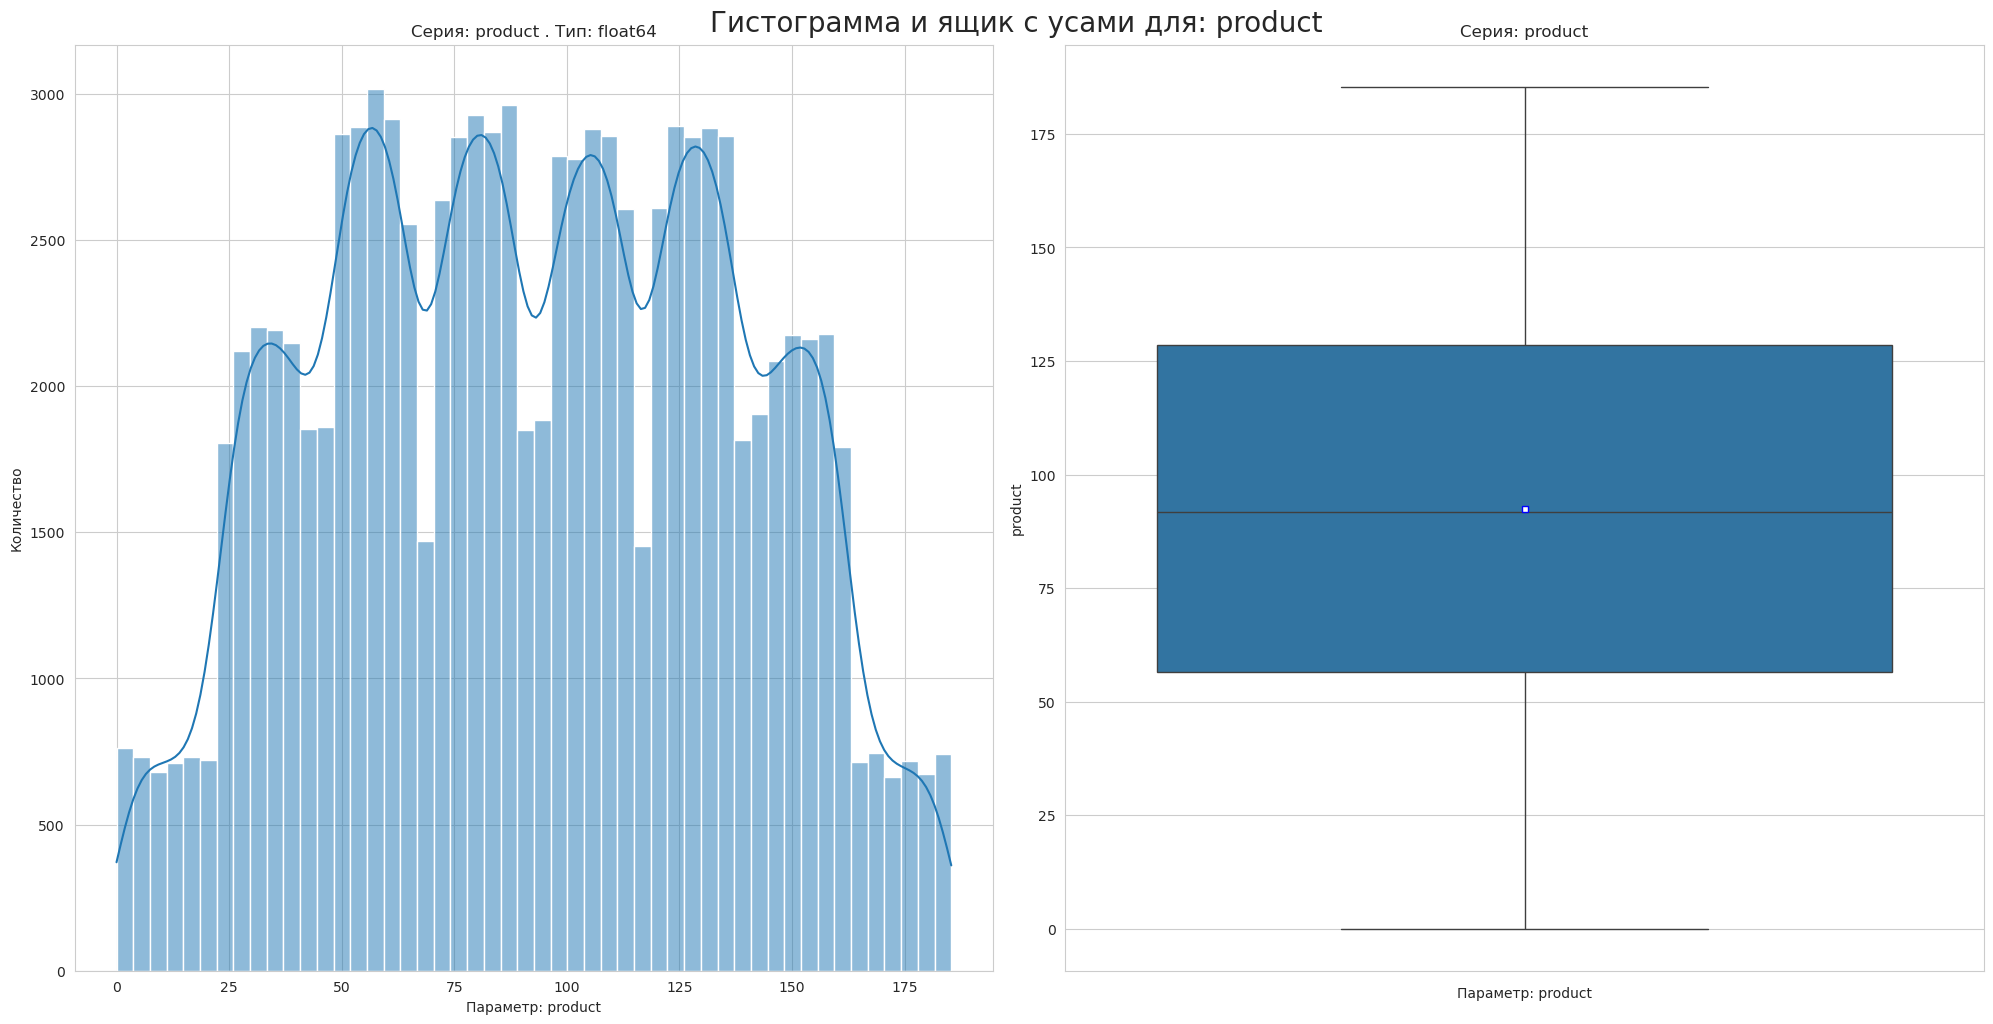

In [31]:
histnbox_plot_for_feature(geo_data_0, 'product')

<div class="alert alert-info">
<h4>📌 Комментарий студента.<a class="tocSkip"> </h4>
    Прикольно, честно признаться не задумылвался над таким подходом. Учту на будущее, спасибо!
</div> 

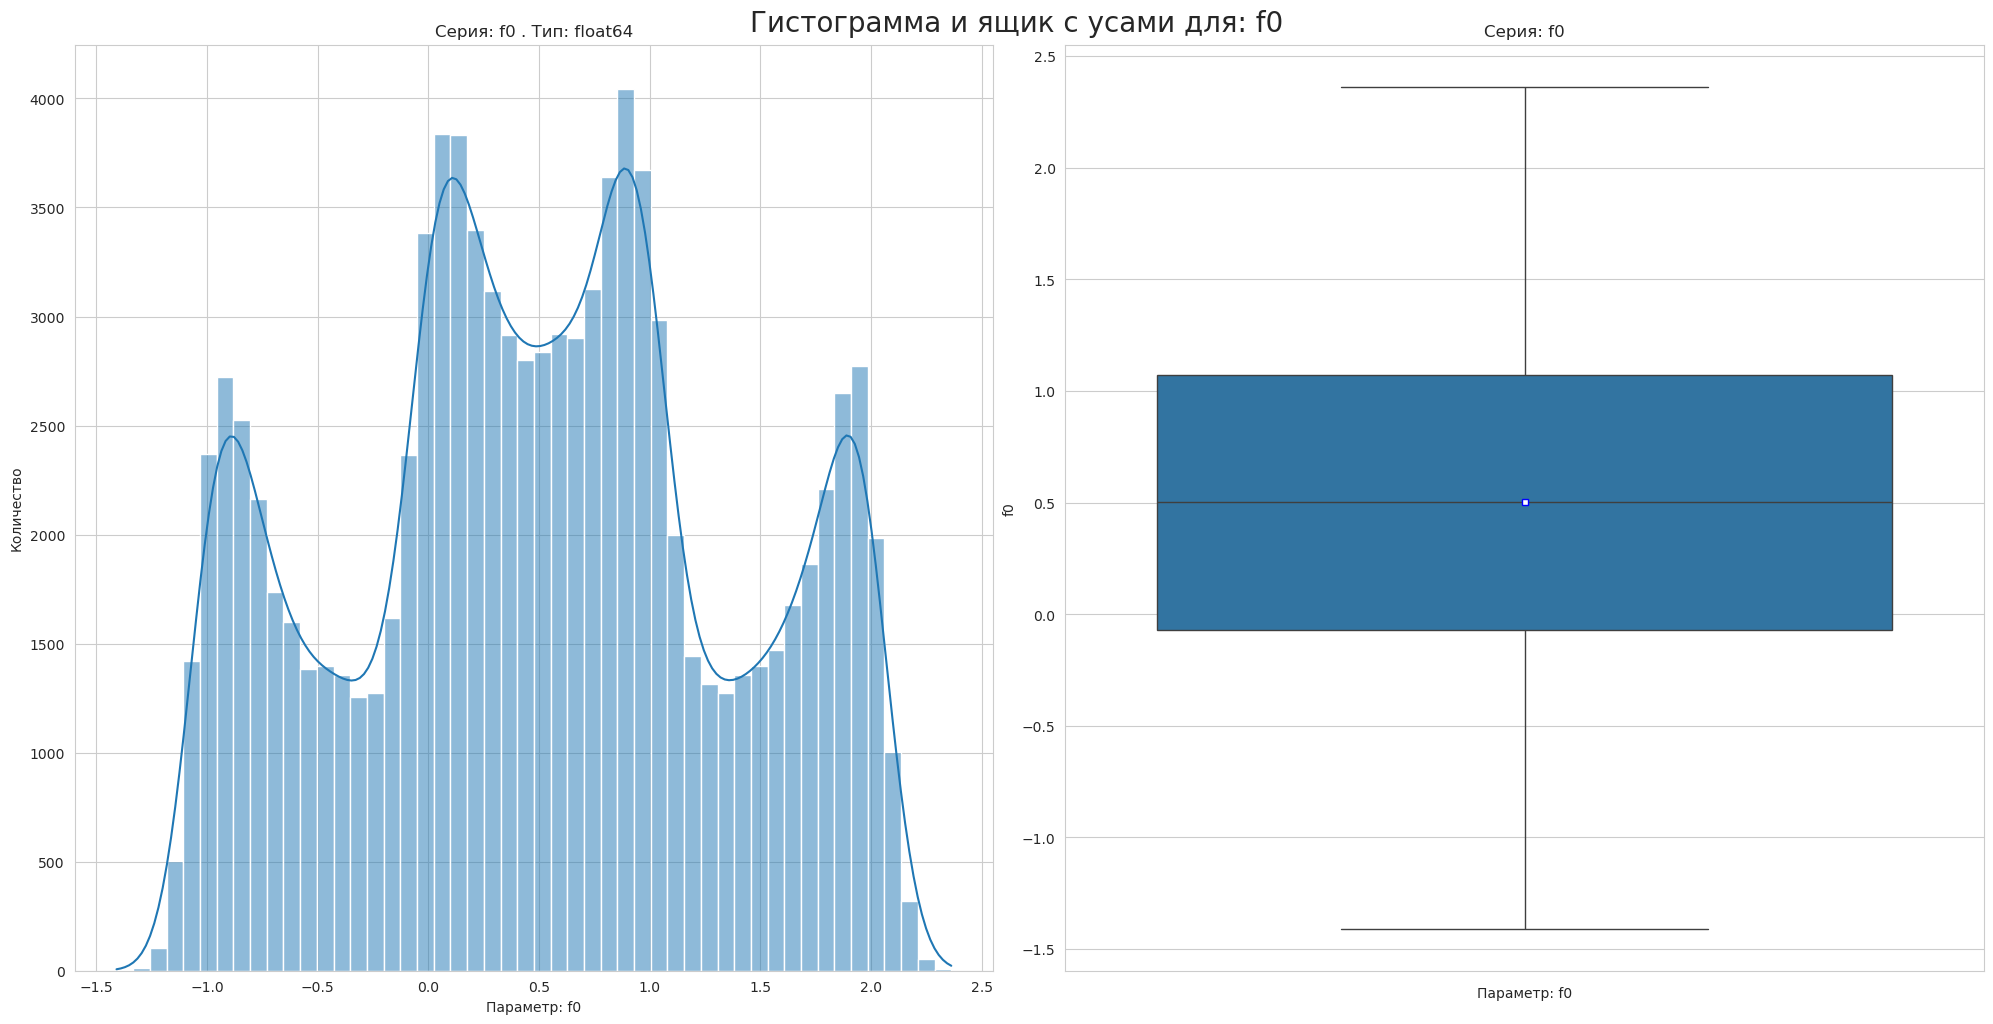

In [32]:
histnbox_plot_for_feature(geo_data_0, 'f0')

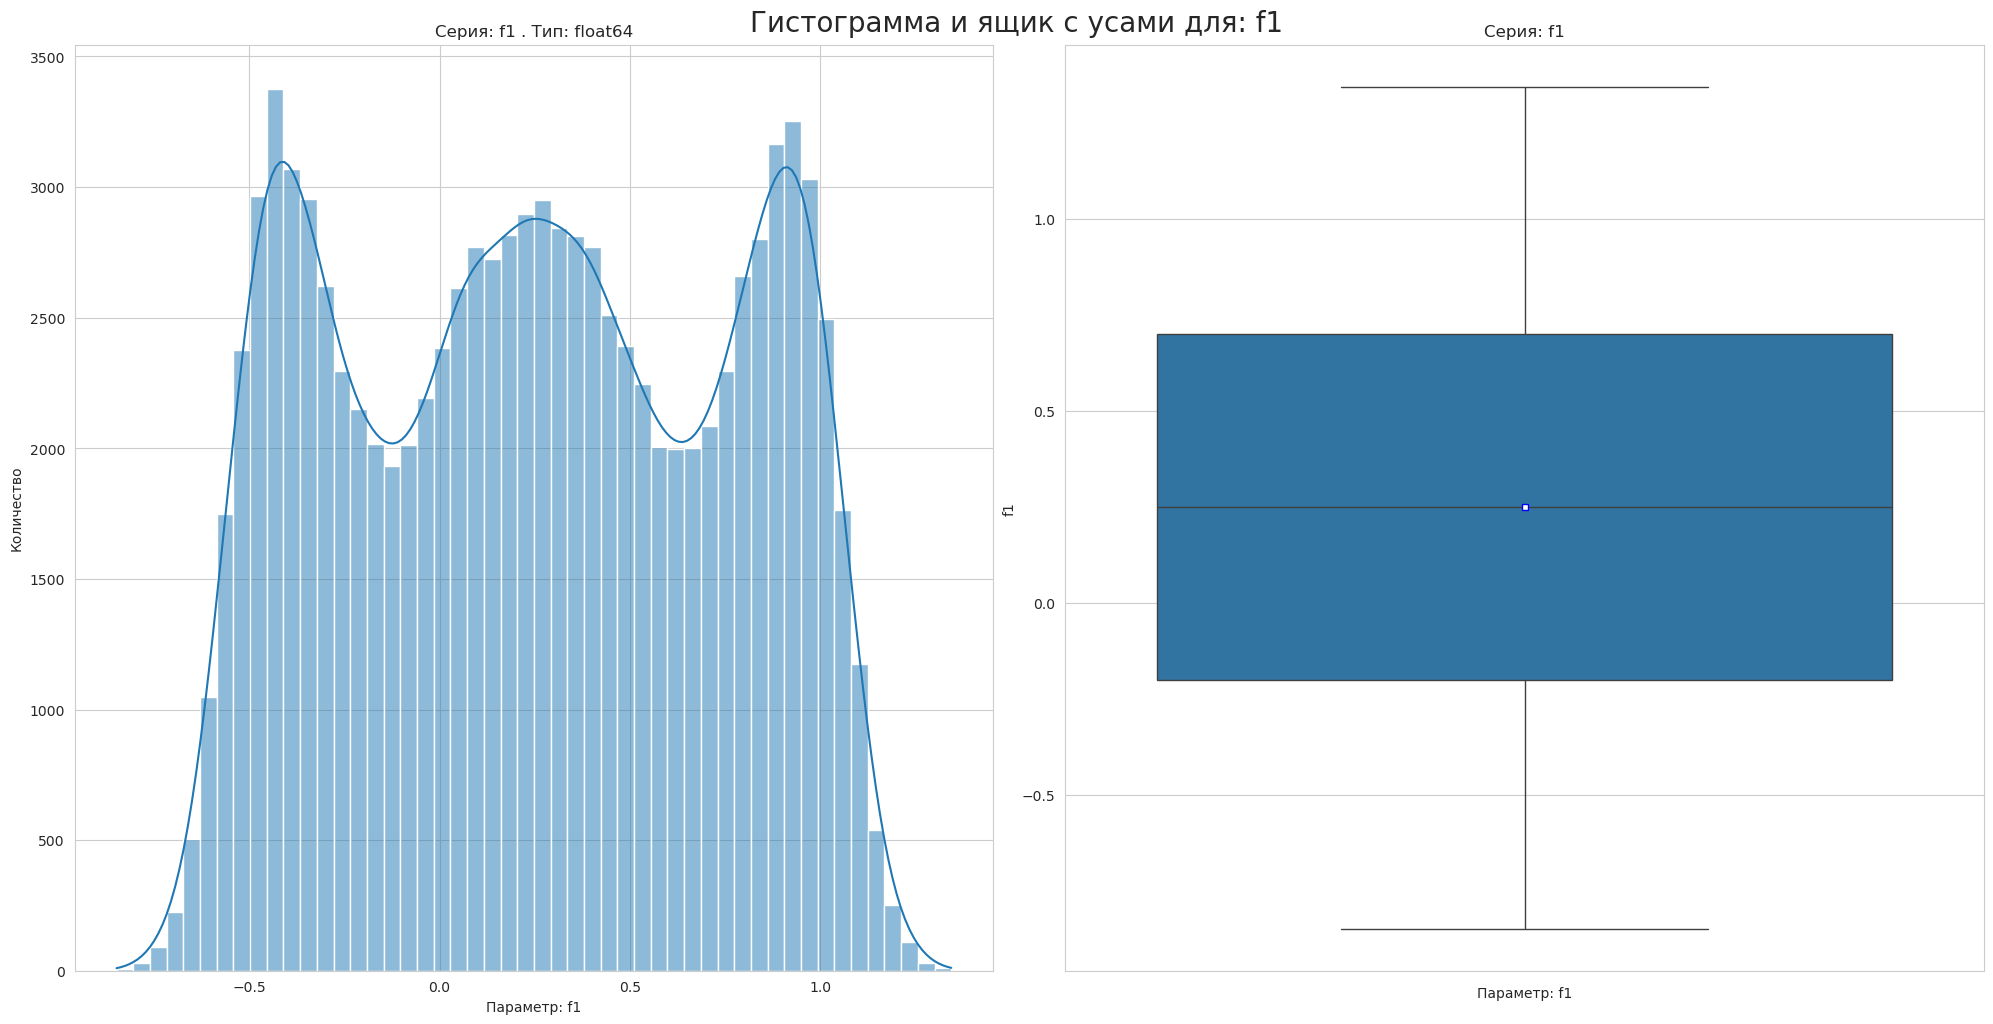

In [33]:
histnbox_plot_for_feature(geo_data_0, 'f1')

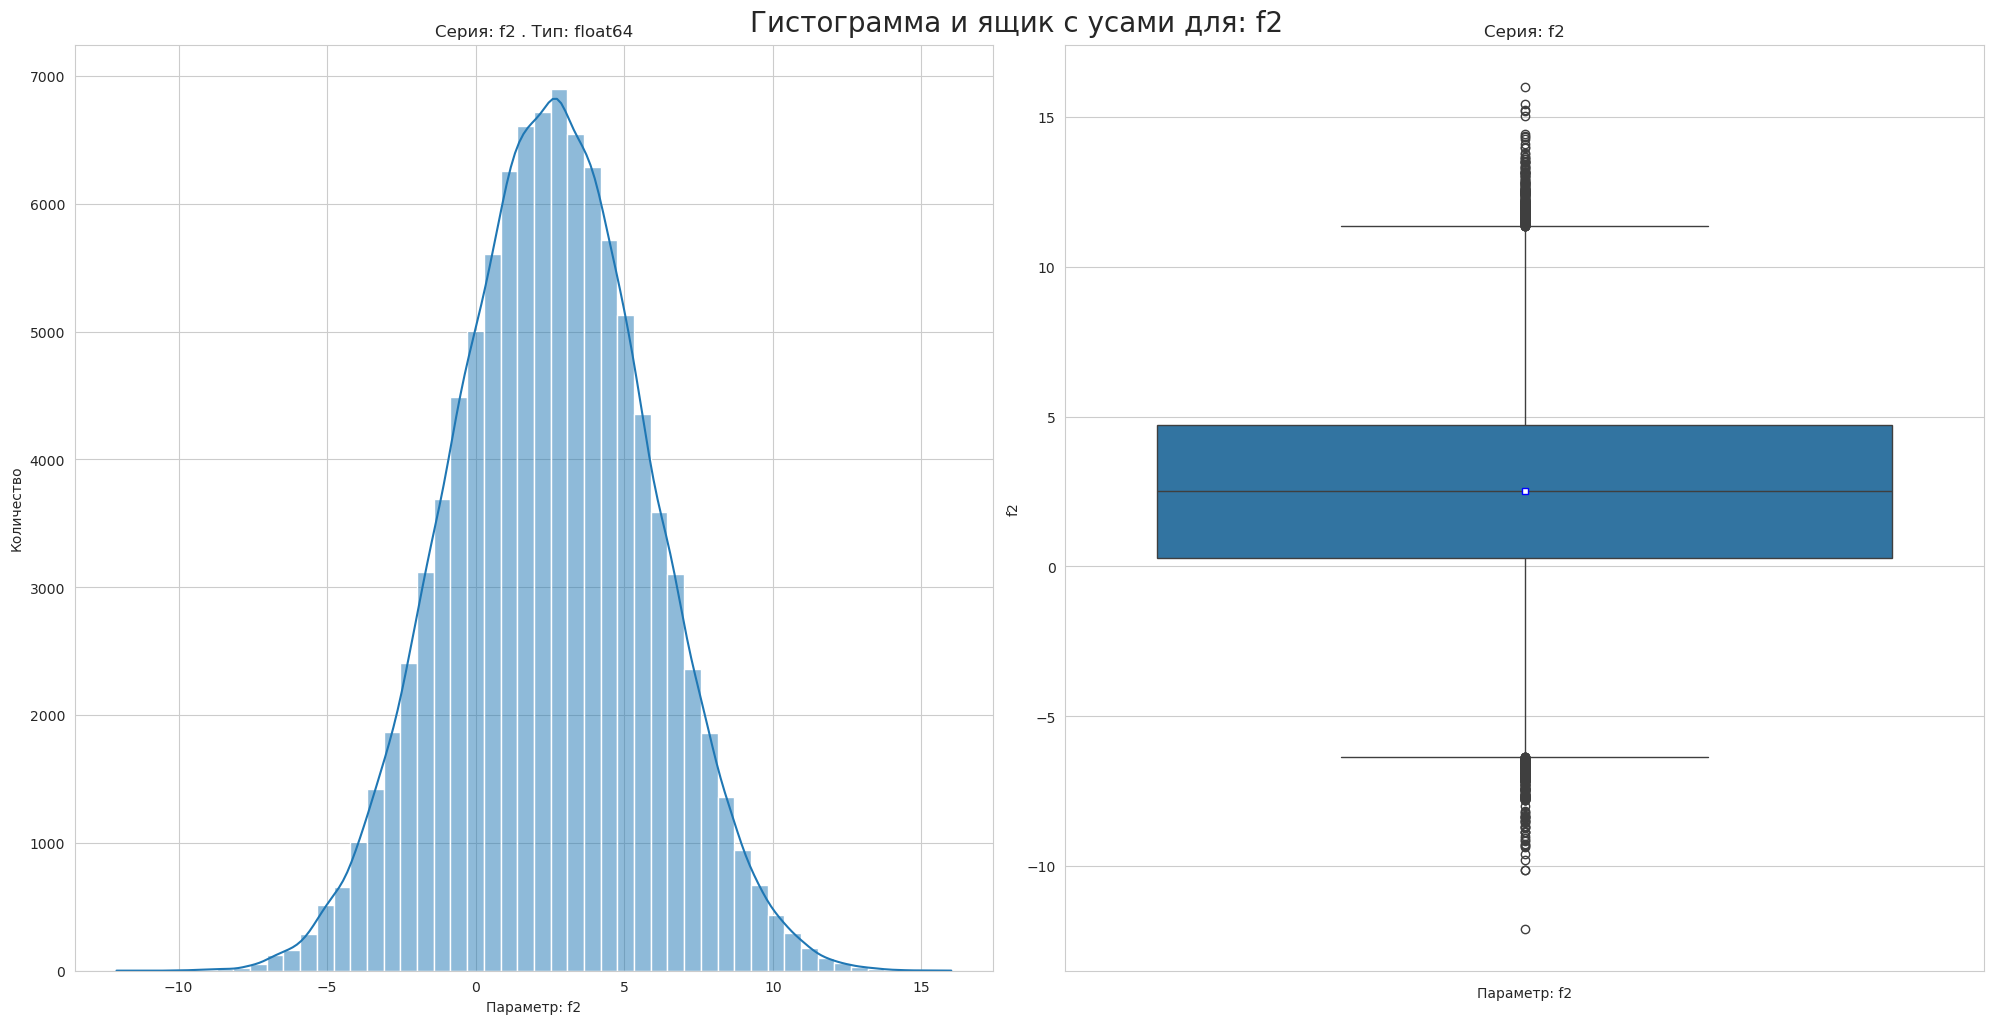

In [34]:
histnbox_plot_for_feature(geo_data_0, 'f2')

**Промежуточный вывод**

Есть выбросы в серии f2. Нужно изучить дополнительно. 
Так же видим, что данные распределены не нормально и отчетливо прослеживатеся 8 сегментов. Кроме того видно что колличество пиков бимодальности в признаке product по сумме совпадает с пиками признаков f0,f1,f2. Сложно объяснить, что это за явление,но похоже, что это не случайность.

In [35]:
# Посмотрим сколько у нас строк с выбросами
len(geo_data_0.loc[(geo_data_0.f2 < -6)]), len(geo_data_0.loc[(geo_data_0.f2 > 11)])

(370, 381)

In [36]:
# Удалим выбросы
geo_data_0.drop(labels=geo_data_0.loc[(geo_data_0.f2 < -6) | (geo_data_0.f2 > 11)].index,axis=0,inplace=True)

In [37]:
# Контроль
len(geo_data_0.loc[(geo_data_0.f2 < -6)]), len(geo_data_0.loc[(geo_data_0.f2 > 11)])

(0, 0)

**Промежуточный вывод**

Несмотря на то, что нам неизвестно назначение признаков f, тем неменее визуально видно что это части одного процесса

##### Проверка на нелинейную зависимость

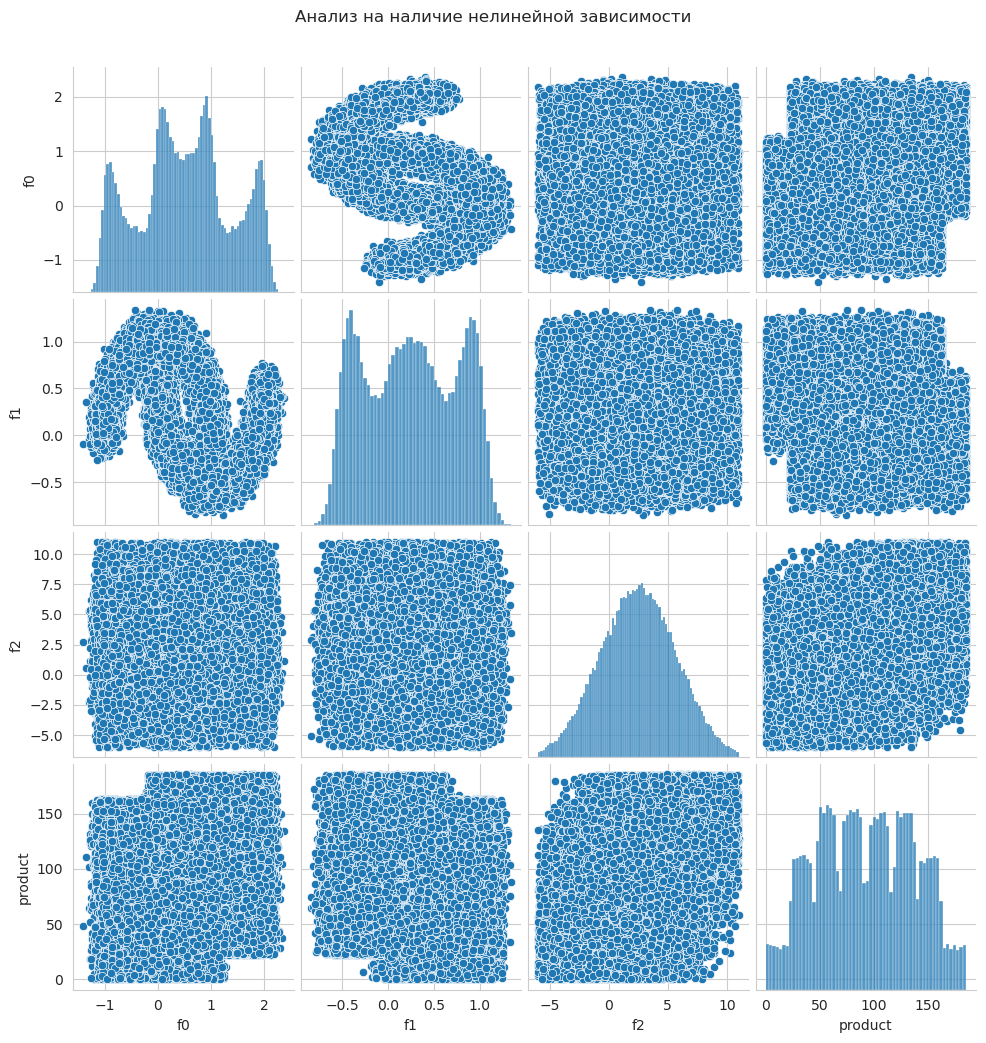

In [38]:
g = sns.pairplot(geo_data_0.drop(columns={'id'}))
g.fig.suptitle('Анализ на наличие нелинейной зависимости', y=1.04)
plt.show()

**Промежуточный вывод**

Наблюдается нелинейная зависимость между признаками f0 и f1. Данный эффект необходимо максимально минимизировать так как, модель линейной регрессии способна фиксировать закономерности только между данными с линейной зависимостью

In [39]:
# Для минимизации нелинейной зависимости, проведем трансформацию признака f0 И f1
transform_f0 = lambda x: x**2
transform_f1 = lambda x: x**2

geo_data_0['f0_transformed'] = transform_f0(geo_data_0.f0)
geo_data_0['f1_transformed'] = transform_f1(geo_data_0.f1)

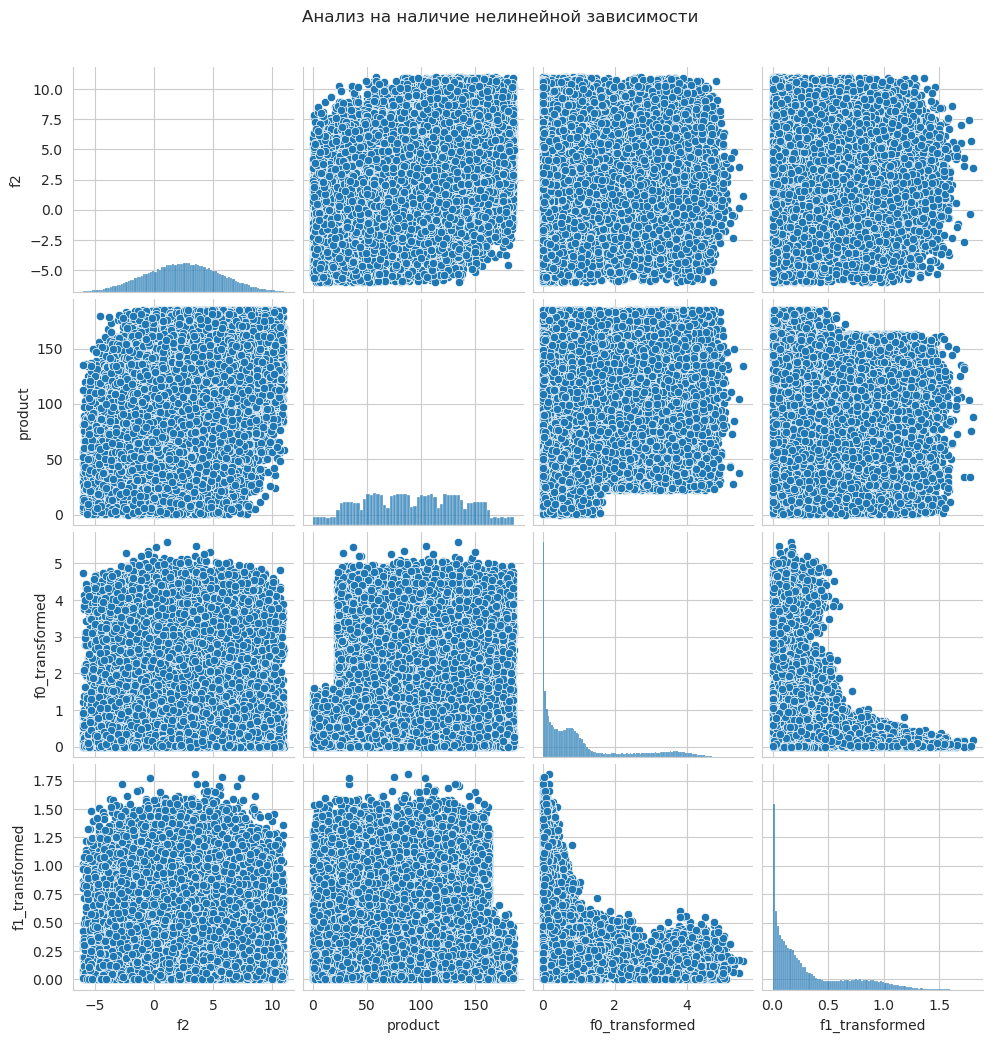

In [40]:
g = sns.pairplot(geo_data_0.drop(columns={'id','f0','f1'}))
g.fig.suptitle('Анализ на наличие нелинейной зависимости', y=1.04)
plt.show()

**Промежуточный вывод**

Благодаря проведенной трансформации признаков f0 и f1 в полиномы второй степени удалось значительно уменьшить нелинейную зависимость между этими признаками

##### Проверка на мультиколениарную зависимость

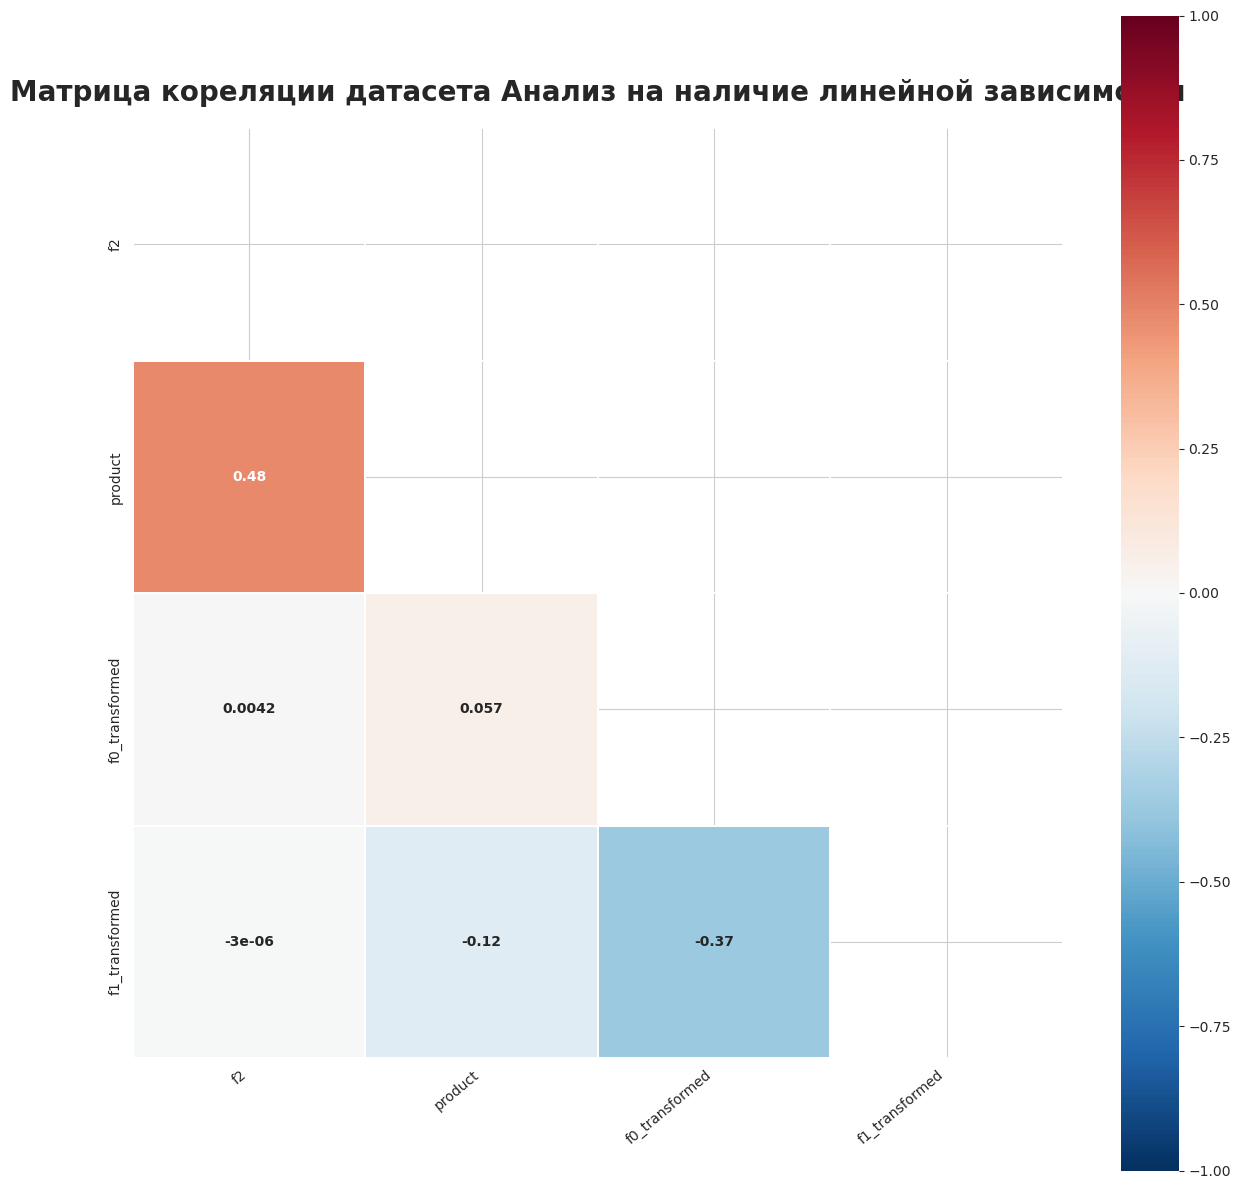

In [41]:
plot_corr_heatmap(geo_data_0.drop(columns={'id','f0','f1'}),"Анализ на наличие линейной зависимости")

**Промежуточный вывод**

Мультиколениарности нет

##### Выводы

Мы провели детальный анализ данных георазведки 1. Анализ показал, что критических аномалий в данных нет. Будем двигаться дальше

#### Осмотр данных георазведки 2

In [42]:
geo_data_1.head()

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

In [43]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [44]:
print(geo_data_1[geo_data_1.isnull().any(axis=1)])

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []


**Промежуточный вывод**

- Все признаки из описания проекта на месте, нет ничего лишнего;
- Значения ячеек выглядат реалистично и уникально;
- Типы признаков определены правильно;
- Пропуски отсутствуют;

##### Проверка на дубликаты

In [45]:
geo_data_1[geo_data_1.duplicated()]

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []

**Промежуточные выводы**

Явные дубликаты отсуствуют, проверим на наличие неявных и вслучае наличия удалим, по тем же причинам что и в первом датасете

In [46]:
geo_data_1.id.duplicated().sum()

4

In [47]:
geo_data_1.drop(labels=geo_data_1[geo_data_1.id.duplicated()].index,axis=0,inplace=True)

In [48]:
geo_data_1.id.duplicated().sum()

0

##### Анализ описательных статистик

In [49]:
geo_data_1.describe().T

count       mean        std        min        25%        50%  \
f0       99996.0   1.141209   8.965815 -31.609576  -6.298551   1.153055   
f1       99996.0  -4.796608   5.119906 -26.358598  -8.267985  -4.813172   
f2       99996.0   2.494501   1.703579  -0.018144   1.000021   2.011475   
product  99996.0  68.823916  45.944663   0.000000  26.953261  57.085625   

                75%         max  
f0         8.620964   29.421755  
f1        -1.332816   18.734063  
f2         3.999904    5.019721  
product  107.813044  137.945408

In [50]:
# Вывод всех строк со скважиными с нулевыми показателями запасов нефти
len(geo_data_1.loc[(geo_data_1['product'] == 0)])

8235

**Промежуточный вывод**

Чтож 8т. строк это не 1, но так же как и в первом датасете наблюдаем у всех признаков реалистичные описания, не обращаем внимание на 0 в product, так как приняли решение оставлять эти строки как существенные для прогноза объема добычи в новых скважинах

##### Анализ выбросов

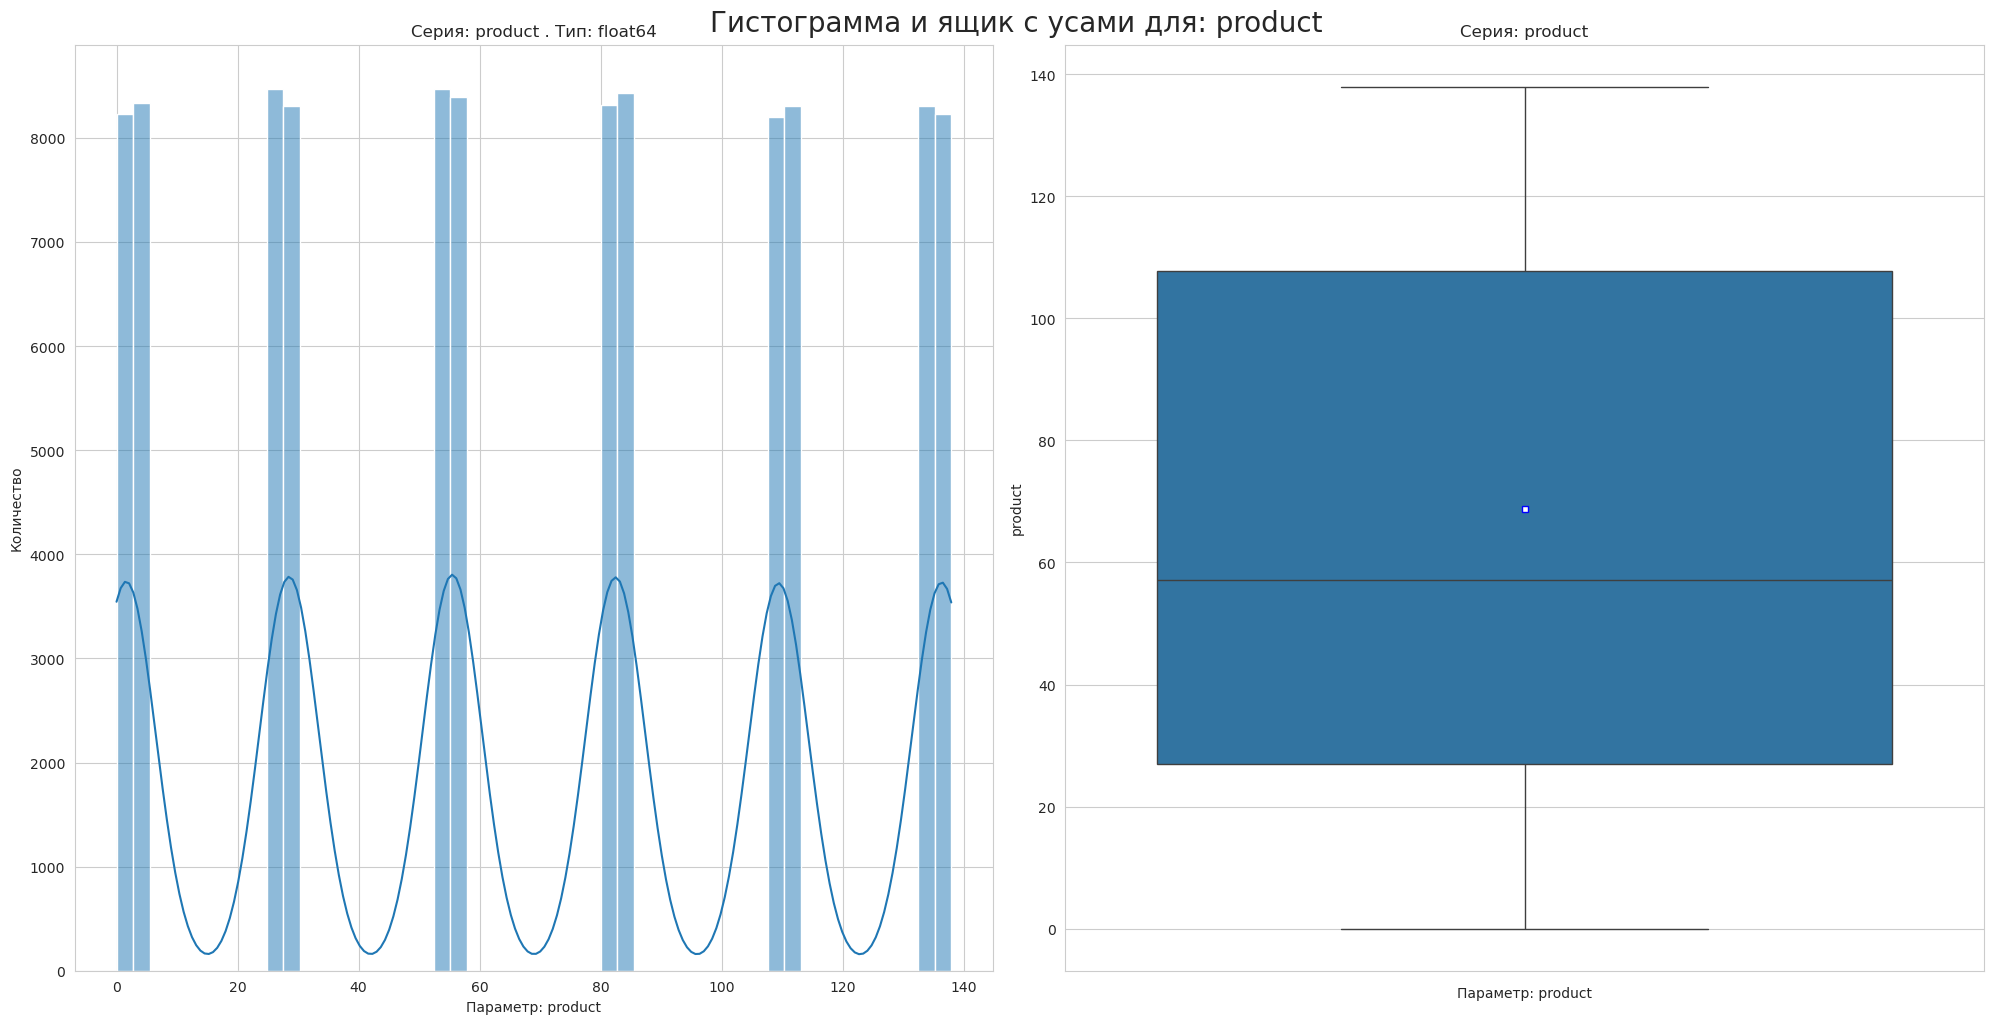

In [51]:
histnbox_plot_for_feature(geo_data_1, 'product')

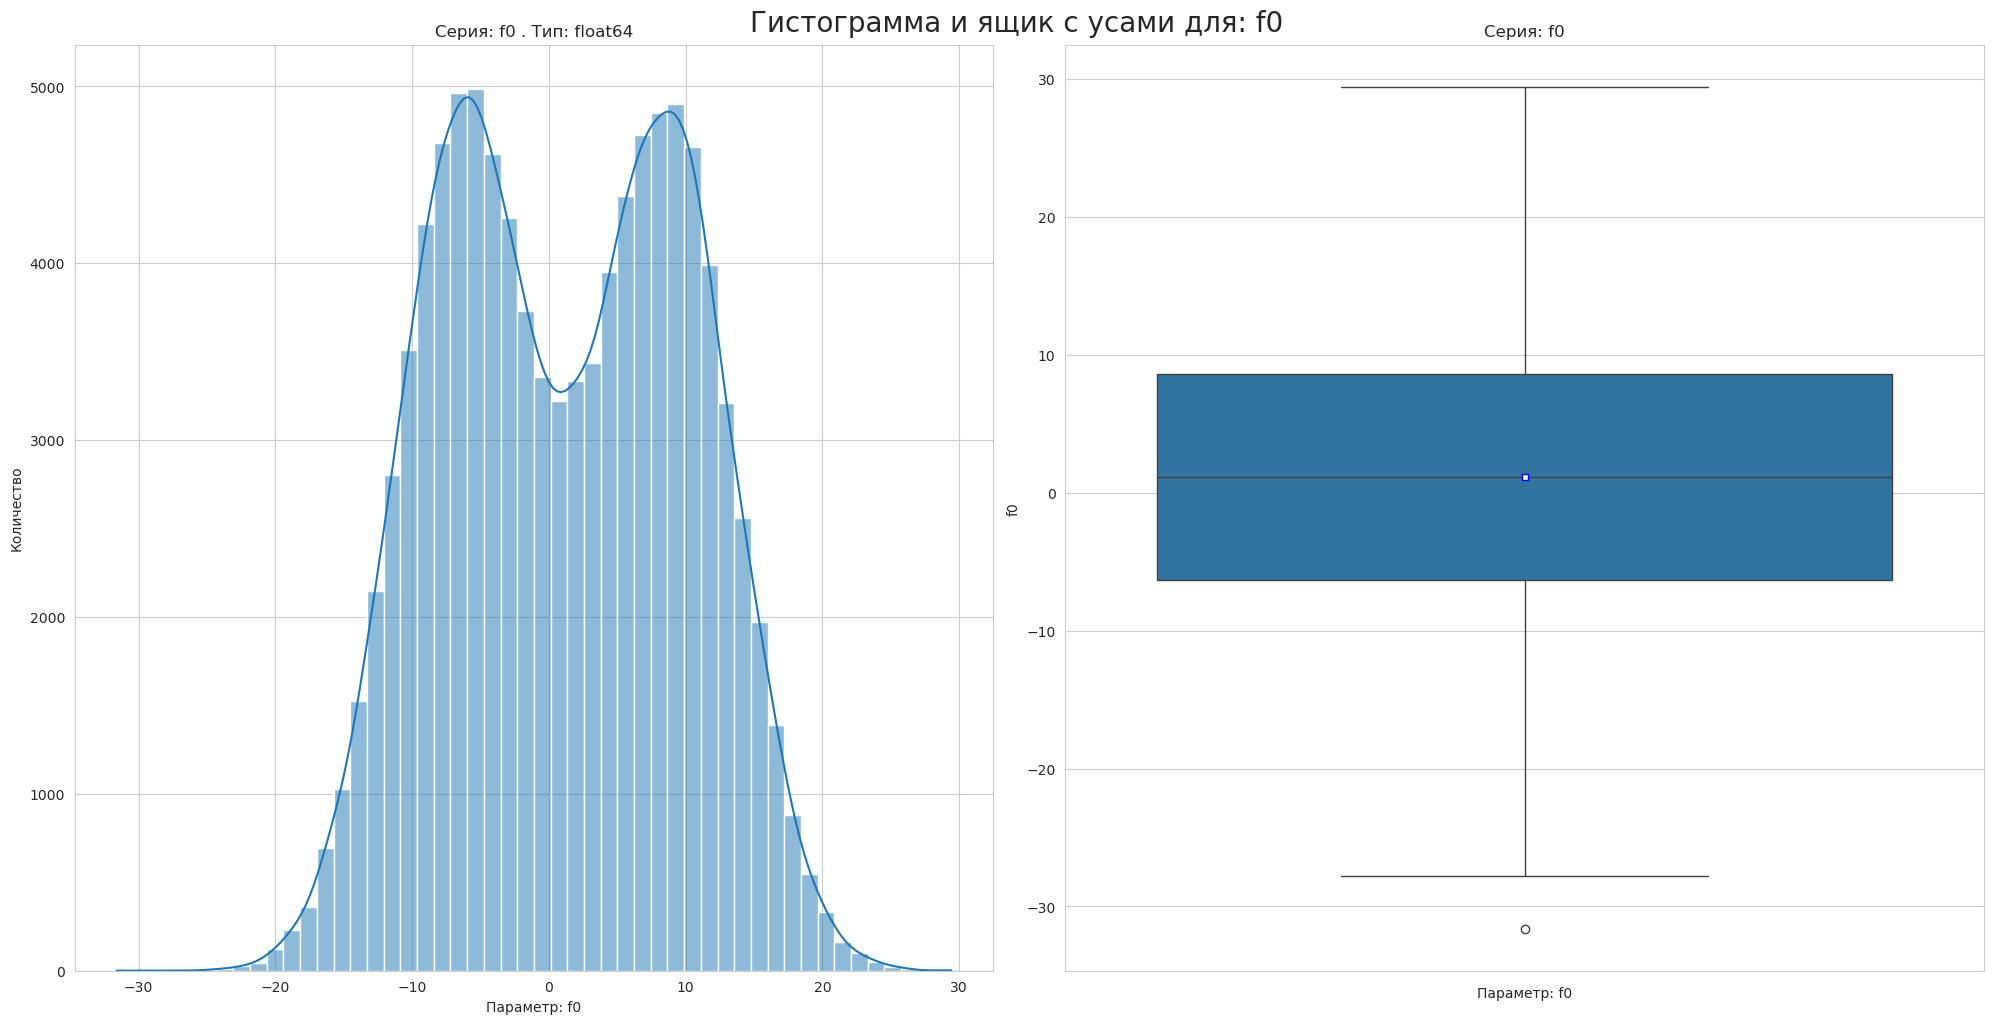

In [52]:
histnbox_plot_for_feature(geo_data_1,'f0')

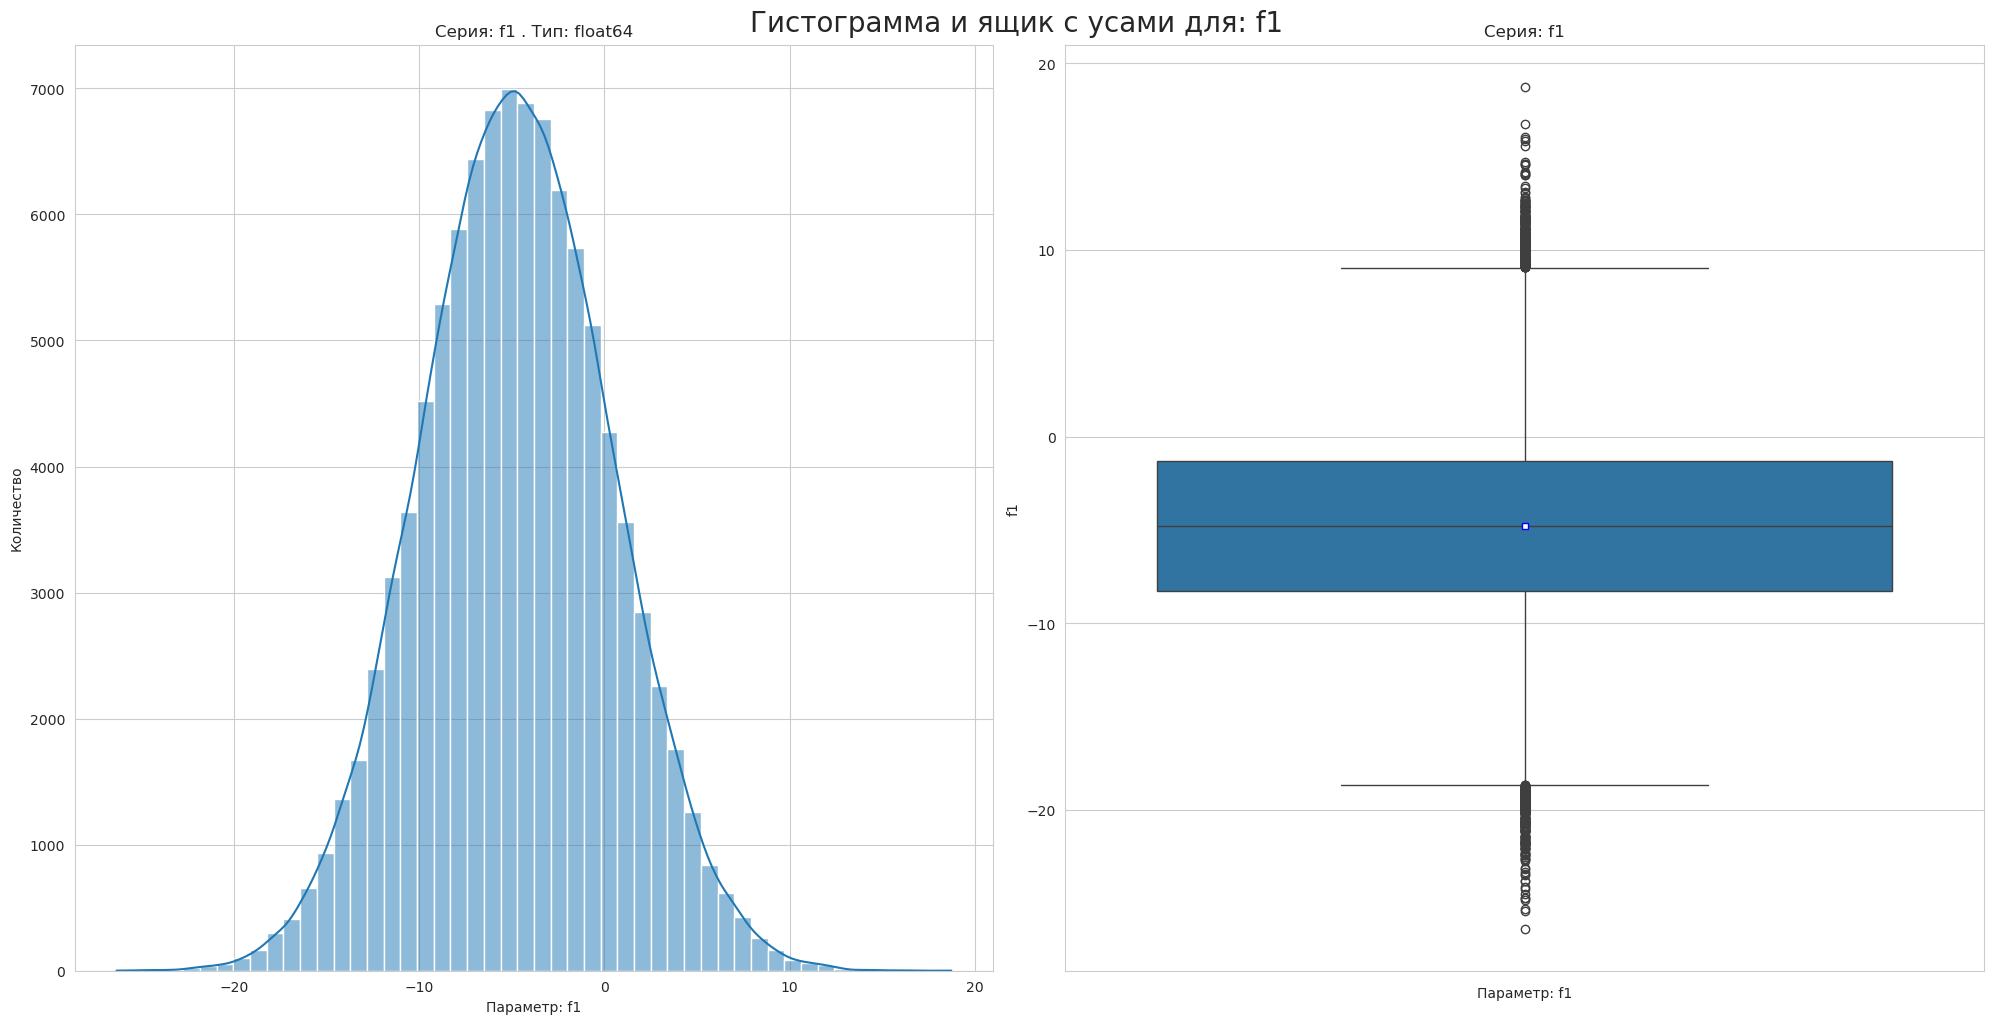

In [53]:
histnbox_plot_for_feature(geo_data_1,'f1')

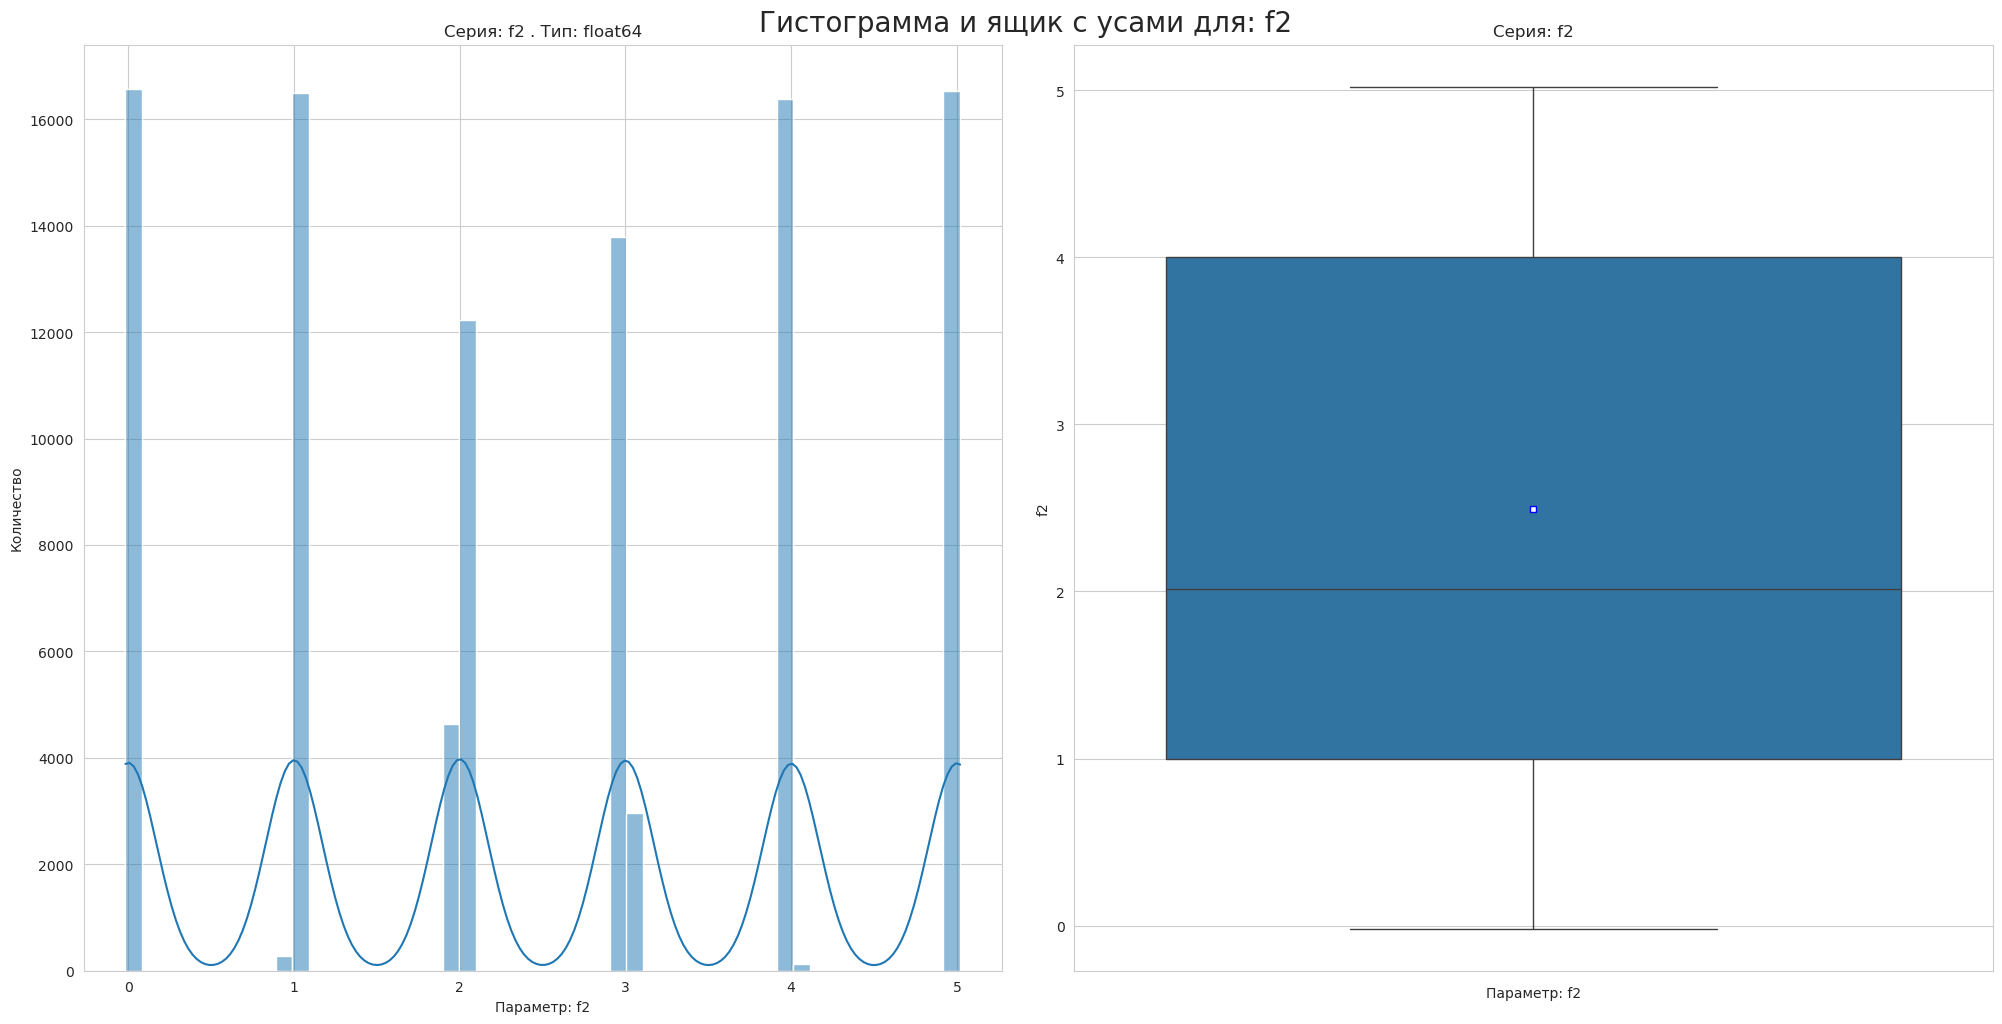

In [54]:
histnbox_plot_for_feature(geo_data_1,'f2')

**Промежуточные выводы**

Видим выбросы в f0 и f1, а так же странное сходство графиков product и f2. Попробуем разобраться отдельно

In [55]:
# Проверим сколько записей с выбросами по f0
len(geo_data_1.loc[geo_data_1.f0 < -30])

1

In [56]:
geo_data_1.drop(labels=geo_data_1.loc[(geo_data_1.f0 < -30)].index,axis=0,inplace=True)

In [57]:
# Контроль
len(geo_data_1.loc[(geo_data_1.f0 <-30)])

0

In [58]:
len(geo_data_1.loc[geo_data_1.f1 < -18]), len(geo_data_1.loc[(geo_data_1.f1 > 8)])

(458, 628)

In [59]:
geo_data_1.drop(labels=geo_data_1.loc[(geo_data_1.f1 < -18) | (geo_data_1.f1 > 8)].index,axis=0,inplace=True)

In [60]:
len(geo_data_1.loc[geo_data_1.f1 < -18]), len(geo_data_1.loc[(geo_data_1.f1 > 8)])

(0, 0)

In [61]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98909 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       98909 non-null  object 
 1   f0       98909 non-null  float64
 2   f1       98909 non-null  float64
 3   f2       98909 non-null  float64
 4   product  98909 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.5+ MB


**Промежуточные выводы**

Количество выбросов было незначительным, поэтому мы их удалили

##### Проверка на не линейную зависимость

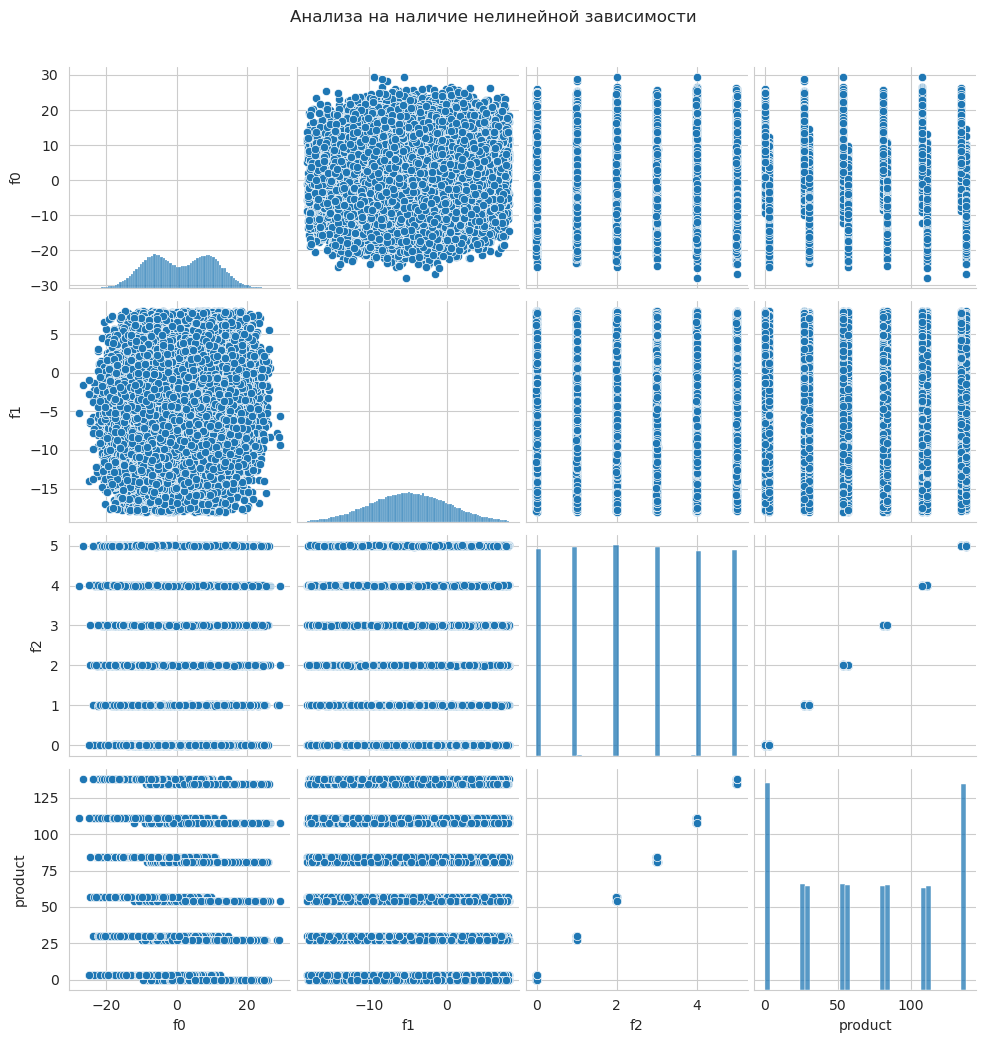

In [62]:
g = sns.pairplot(data= geo_data_1.drop(columns={'id'}))
g.fig.suptitle('Анализа на наличие нелинейной зависимости', y=1.04)
plt.show()

**Промежуточный вывод**

В отличии от предыдущего датасета здесь не наблюдается нелинейно зависимости.
Стоит отметить что наблюдается ярковыраженный восходящий тренд линейной зависимости между product и f2

##### Проверка на мультиколениарную зависимость

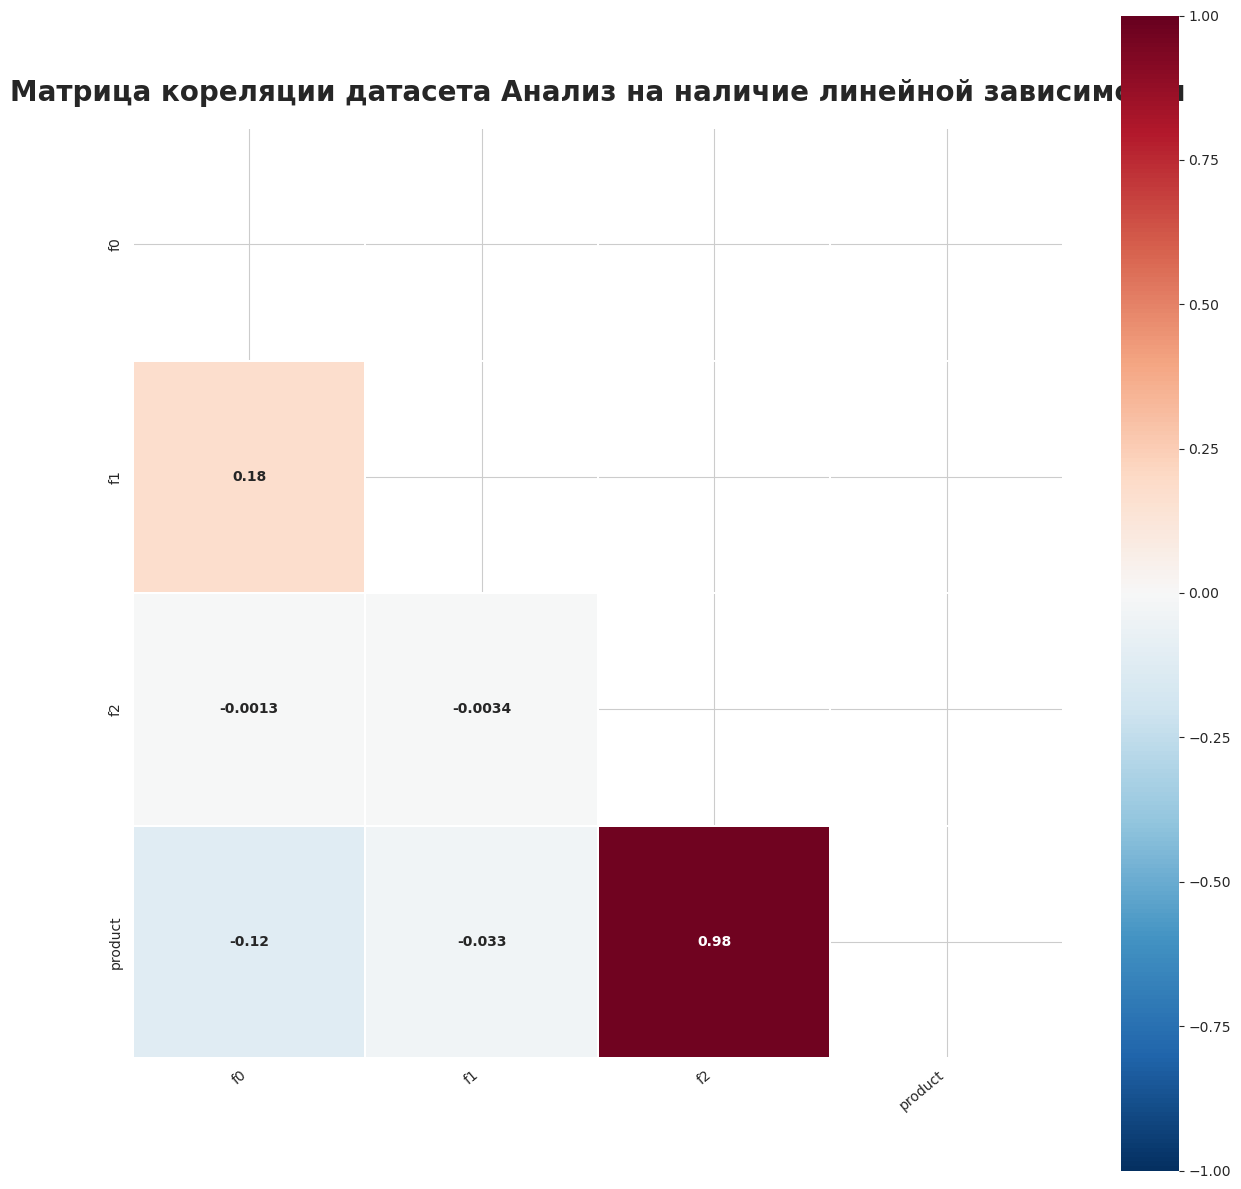

In [63]:
plot_corr_heatmap(geo_data_1.drop(columns={'id'}),"Анализ на наличие линейной зависимости")

**Промежуточные выводы**

Наше подозрение о схожести графиков product и f2 подтверждается наличием кореляции между этими признаками. Это не радетс, так как все три датасета у нас имеют одиннаковое количество признаков и избавиться от одного признака в одном датаесете означает, что мы не сможем воспользоваться ранее обученой моделью так как нам придется обучить модель отдельно, конкретно под этот набор признаков

Удалим признак f2

In [64]:
geo_data_1 = geo_data_1.drop(columns={'f2'}, axis=1)

##### Выводы

Проведен детальный осмотр данных. Была выявленна и устранена мультколениарная зависимость.

#### Осмотр данных георазведки 3

In [65]:
geo_data_2.head()

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

In [66]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [67]:
print(geo_data_2[geo_data_2.isnull().any(axis=1)])

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []


**Промежуточный вывод**

- Все признаки из описания проекта на месте, нет ничего лишнего;
- Значения ячеек выглядат реалистично и уникально;
- Типы признаков определены правильно;
- Пропуски отсутствуют;

##### Проверка на дубликаты

In [68]:
geo_data_2[geo_data_2.duplicated()]

Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []

**Промежуточный вывод**

Явных дубликатов нет. Проверим на неявные

In [69]:
geo_data_2.id.duplicated().sum()

4

**Промежуточный вывод**

Есть неявные дубликаты, удалим по тем же причинам

In [70]:
geo_data_2.drop(labels=geo_data_2[geo_data_2.id.duplicated()].index,axis=0,inplace=True)

In [71]:
geo_data_2.id.duplicated().sum()

0

##### Анализ описательных статистик

In [72]:
geo_data_2.describe().T

count       mean        std        min        25%        50%  \
f0       99996.0   0.002002   1.732052  -8.760004  -1.162328   0.009424   
f1       99996.0  -0.002159   1.730397  -7.084020  -1.174841  -0.009661   
f2       99996.0   2.495084   3.473482 -11.970335   0.130269   2.484236   
product  99996.0  94.998342  44.749573   0.000000  59.450028  94.925026   

                75%         max  
f0         1.158477    7.238262  
f1         1.163523    7.844801  
f2         4.858720   16.739402  
product  130.586815  190.029838

In [73]:
# Вывод всех строк со скважиными с нулевыми показателями запасов нефти
len(geo_data_2.loc[(geo_data_2['product'] == 0)])

1

**Промежуточный вывод**

Так же как и в первом датасете наблюдаем у всех признаков реалистичные описания, не обращаем внимание на 0 в product, так как приняли решение оставлять эти строки как существенные для прогноза объема добычи в новых скважинах

##### Анализ выбросов

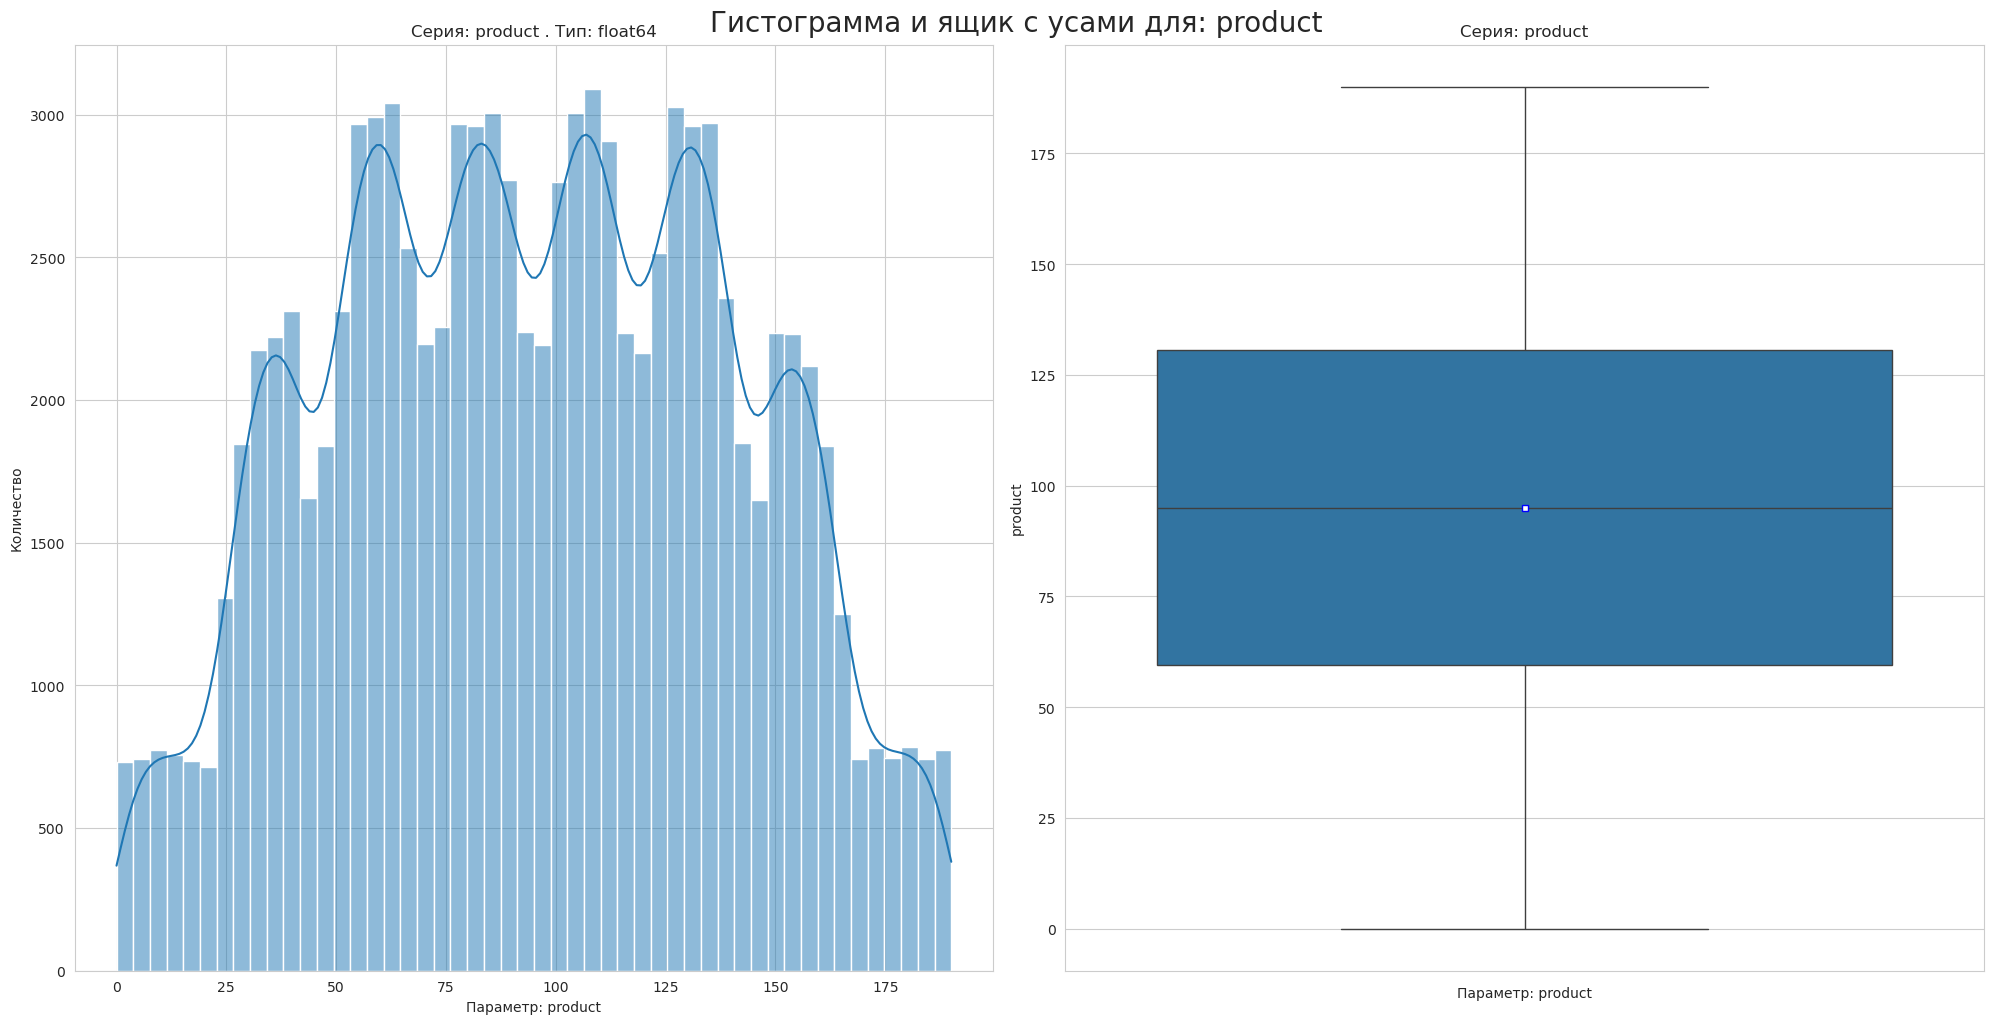

In [74]:
histnbox_plot_for_feature(geo_data_2,"product")

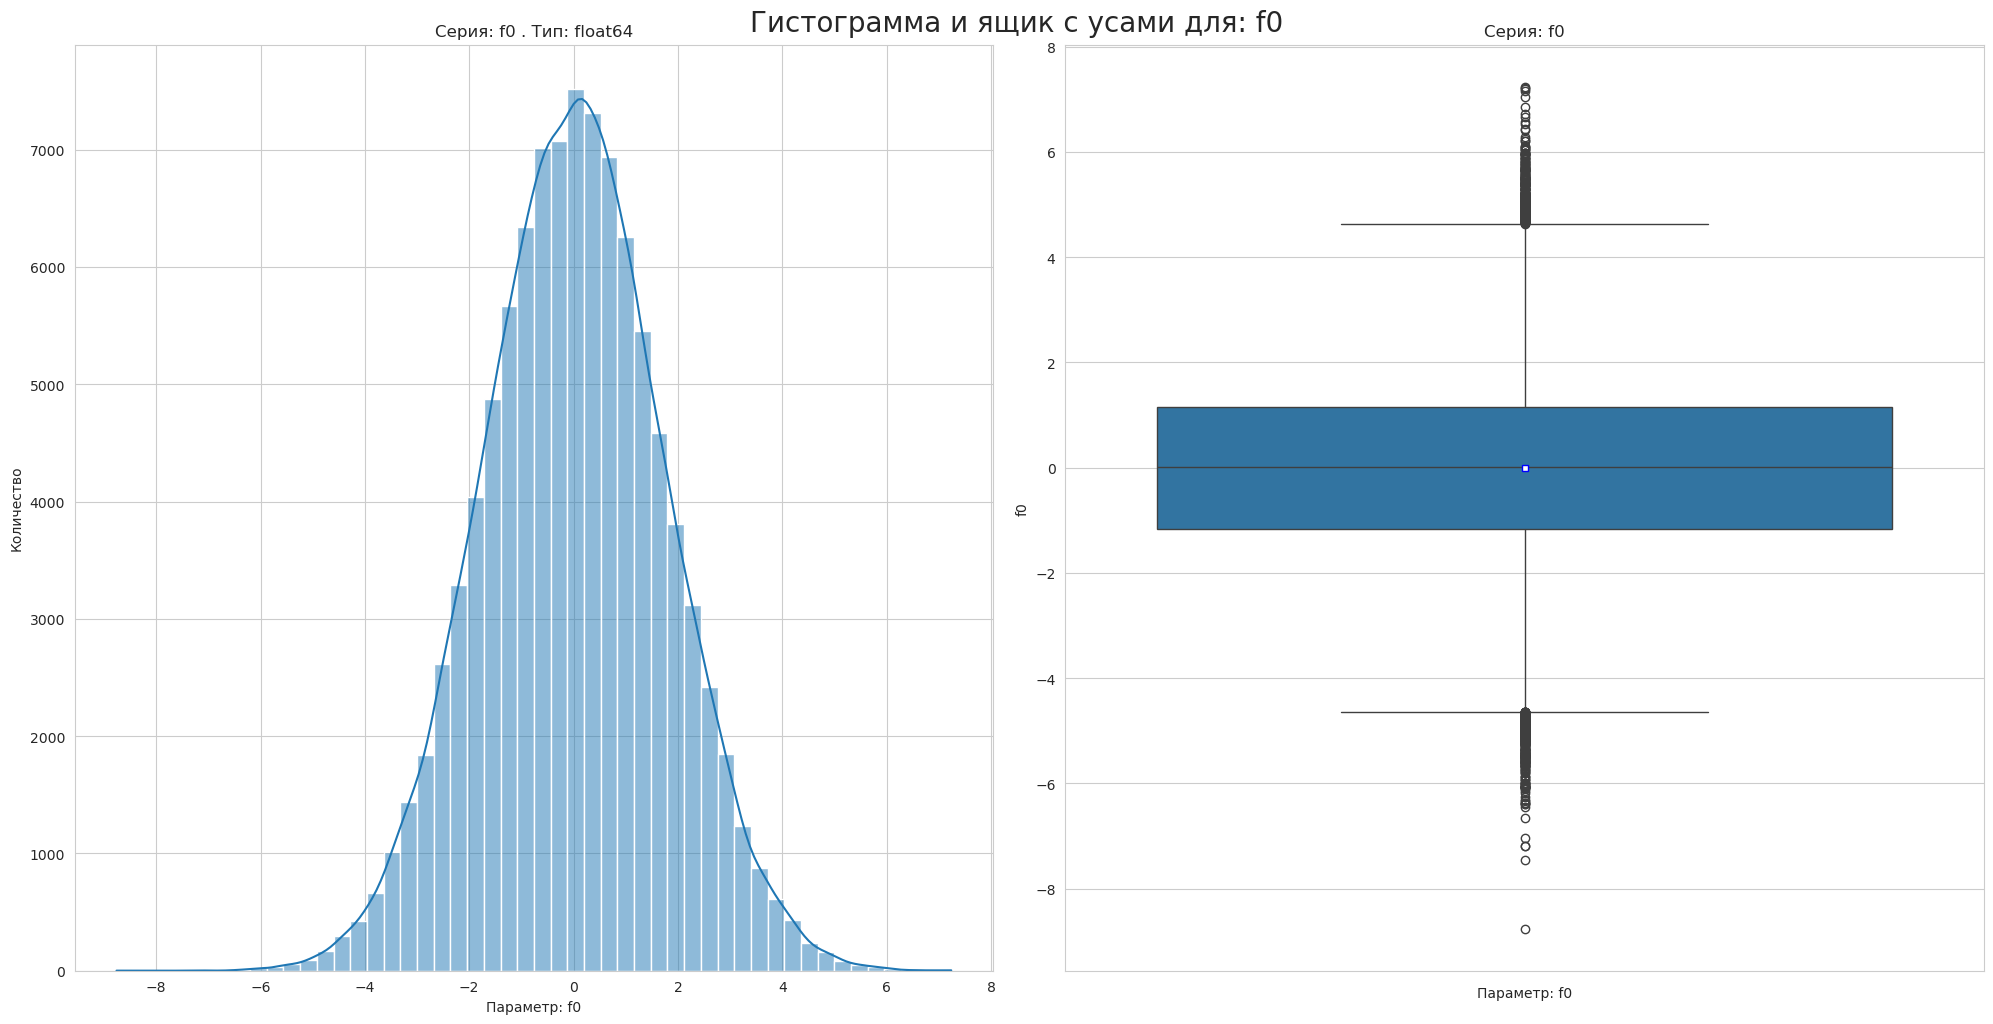

In [75]:
histnbox_plot_for_feature(geo_data_2,'f0')

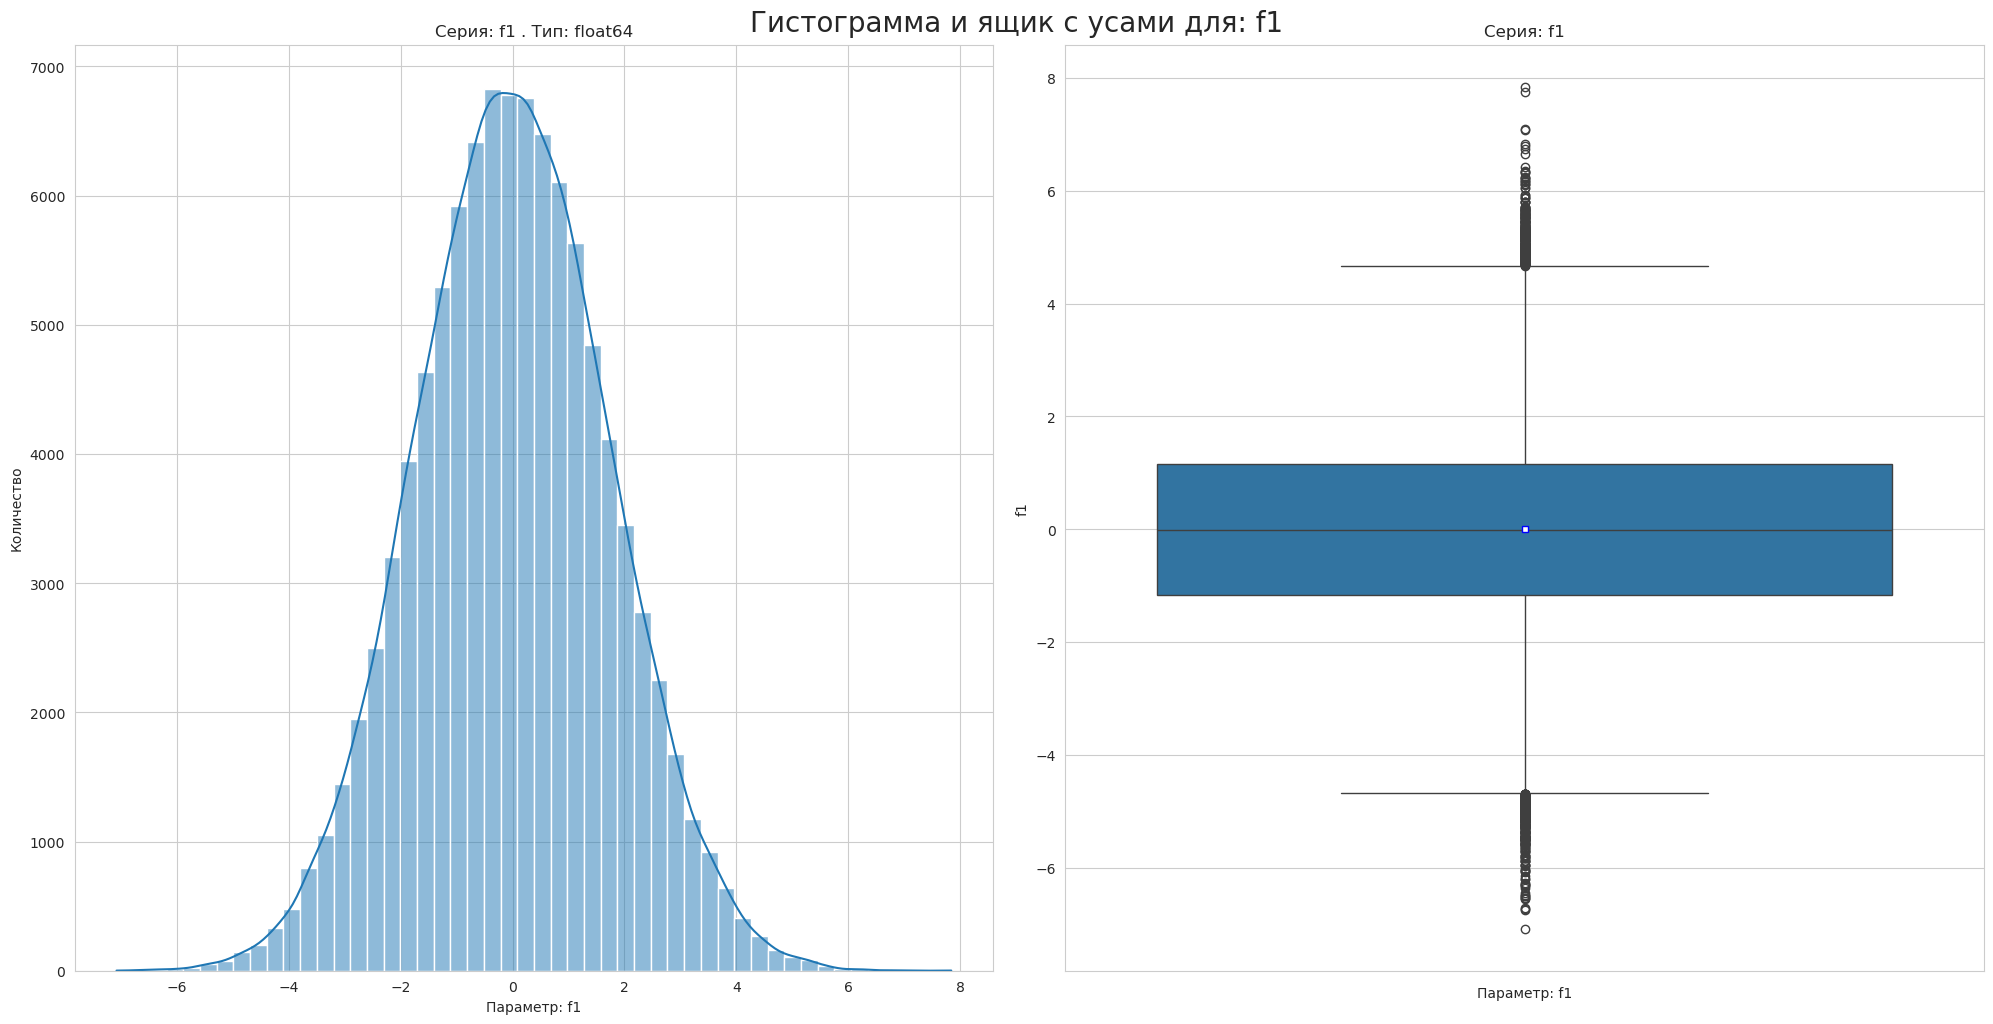

In [76]:
histnbox_plot_for_feature(geo_data_2,'f1')

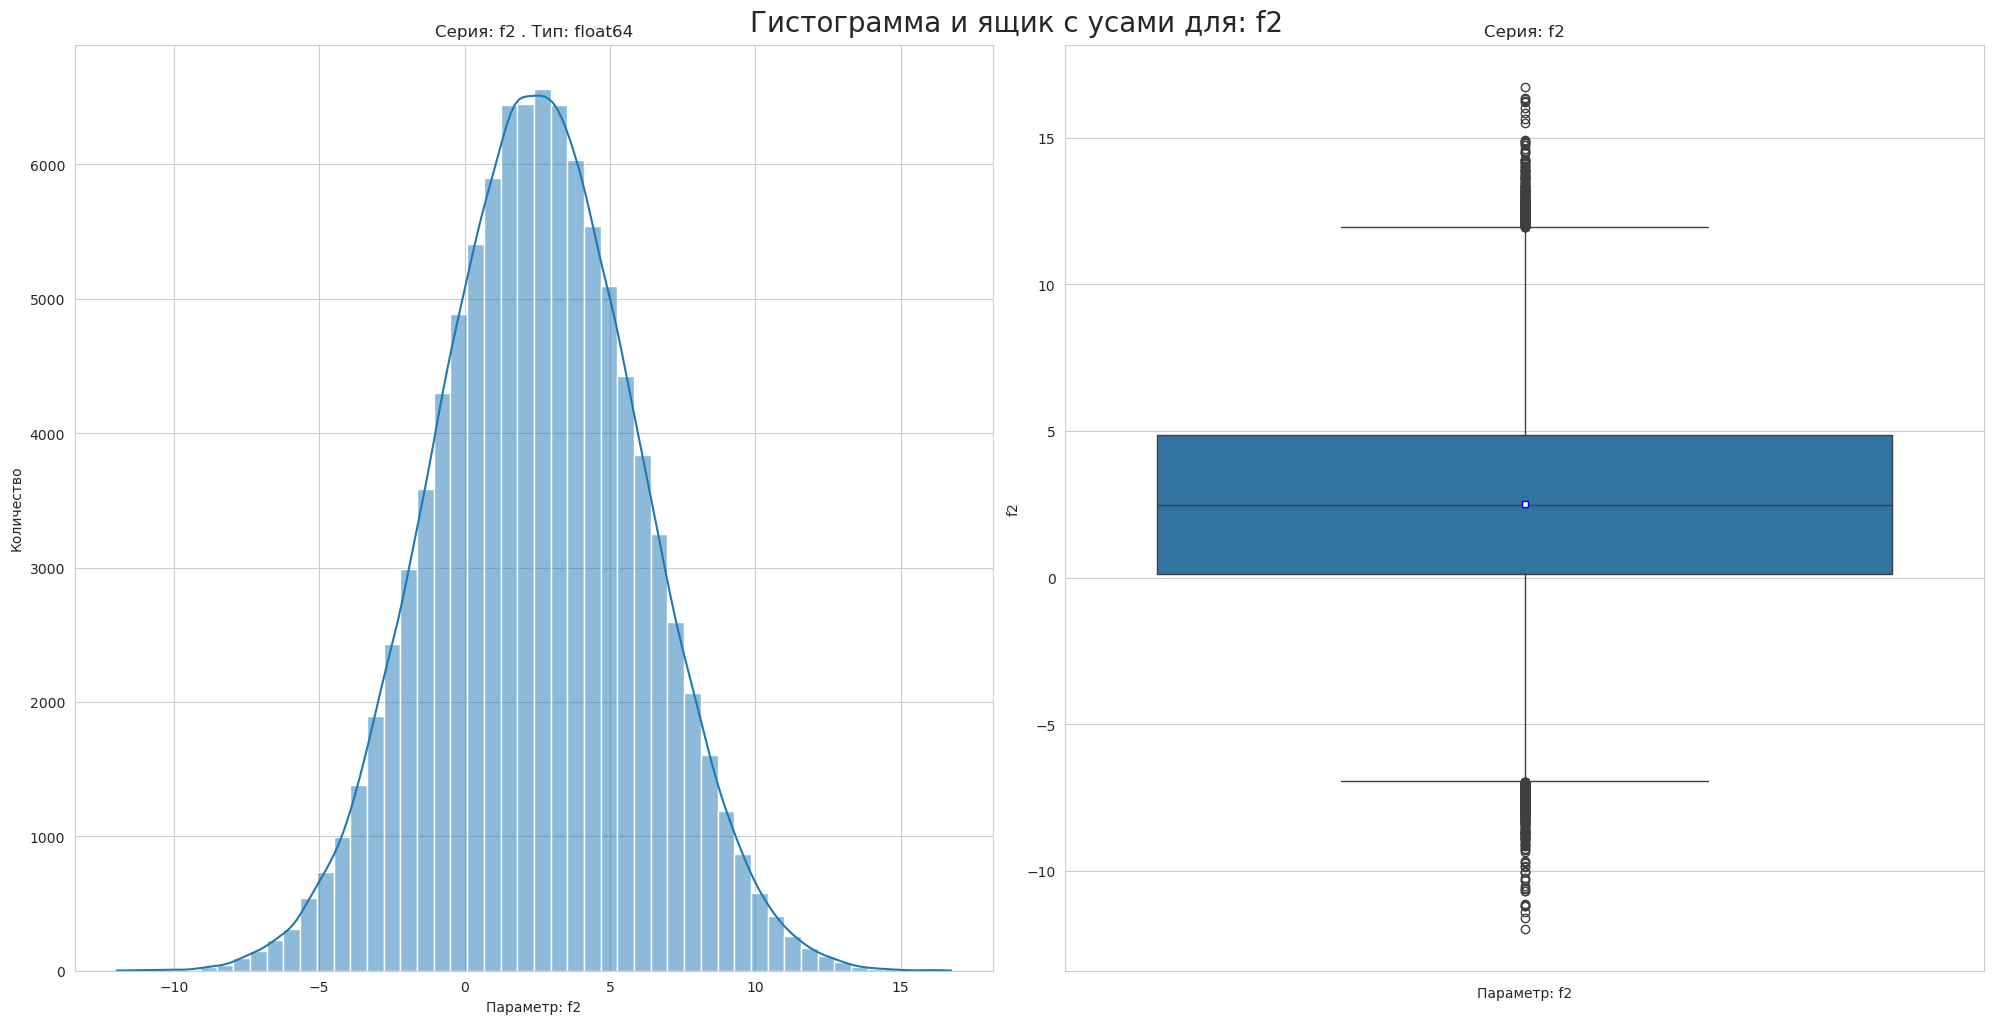

In [77]:
histnbox_plot_for_feature(geo_data_2,'f2')

**Промежуточный вывод**

По product наблюдается бимодальность. По остальным признакам наблюдаются выбросы, надо понять их количество и по-возможности удалить.

В целом можно отметить что по характеру распределения данные приближены к Гаусовскому распределению, в особенности это касается признаков f1 и f0. У f2 уже наблюдается смещение в право

In [78]:
# Посмотрим сколько у нас выбросов по f0 признаку
len(geo_data_2.loc[(geo_data_2.f0 >4) | (geo_data_2.f0 < -4)])

2125

In [79]:
# Удалим выбросы
geo_data_2.drop(labels=geo_data_2[(geo_data_2.f0 >4) | (geo_data_2.f0 < -4)].index, axis=0,inplace=True)

In [80]:
#Проверим количество выбросов по f1
len(geo_data_2.loc[(geo_data_2.f1 >4) | (geo_data_2.f1 < -4)])

1993

In [81]:
# Удалим выбросы по f1
geo_data_2.drop(labels=geo_data_2[(geo_data_2.f1 >4) | (geo_data_2.f1 < -4)].index, axis=0,inplace=True)

In [82]:
# Проверим количество выбросов по f2
len(geo_data_2.loc[(geo_data_2.f2 > 11) | (geo_data_2.f2 < -6)])

1304

In [83]:
# Удалим выбросы по f2
geo_data_2.drop(labels=geo_data_2[(geo_data_2.f2 >11) | (geo_data_2.f2 < -6)].index, axis=0,inplace=True)

##### Проверка на нелинейную зависимость

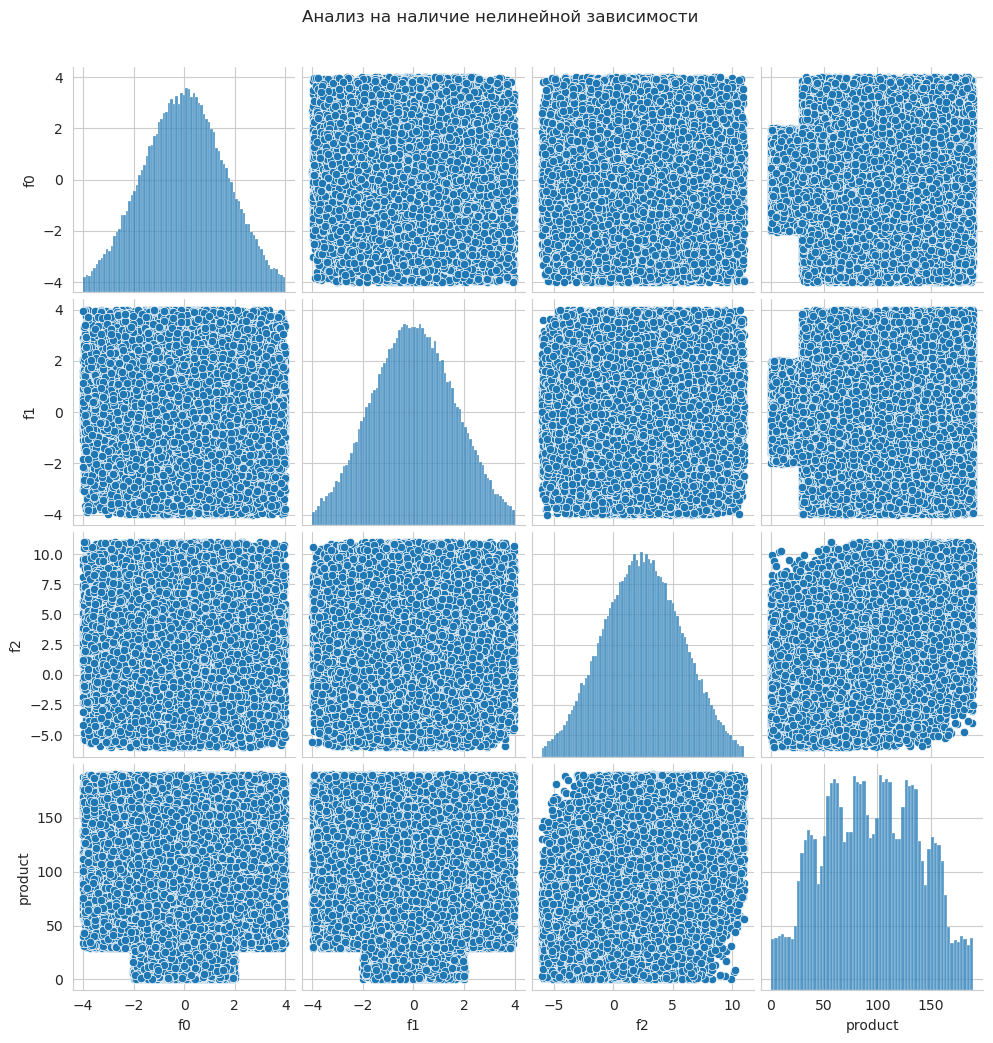

In [84]:
g = sns.pairplot(data=geo_data_2.drop(columns={'id'}))
g.fig.suptitle('Анализ на наличие нелинейной зависимости', y=1.04)
plt.show()

**Промежуточный вывод**

Очень интересный график, на котором мы имеем редкую возможность лицезреть, как выглядит нормально распределение, а так же как выглядит отсутсвие линейной зависимости. Это отчетливо виодно по признакам f0, f1, f2.
С точки зрения модели линейной регрессии это может стать проблеммой, так как она чувствительна к наличию линейной зависимости при расчете весов. Поэтому считаю, что будет правильным выразить более ярко линейную зависимость между этими признаками. 
Сейчас ничего трогать небудем посмотрим на эту проблемму когда дойдем до нормализации

In [85]:
#transform = lambda x: (x - np.mean(x)) / np.std(x)

#geo_data_2['f0_transformed'] = transform(geo_data_2.f0)
#geo_data_2['f1_transformed'] = transform(geo_data_2.f1)
#geo_data_2['f2_transformed'] = transform(geo_data_2.f2)

In [86]:
#g= sns.pairplot(data=geo_data_2.drop(columns={'id','f0','f1','f2'}))
#g.fig.suptitle('Анализ увеличение линейной зависимости')
#plt.show()

##### Проверка на мультиколениарность

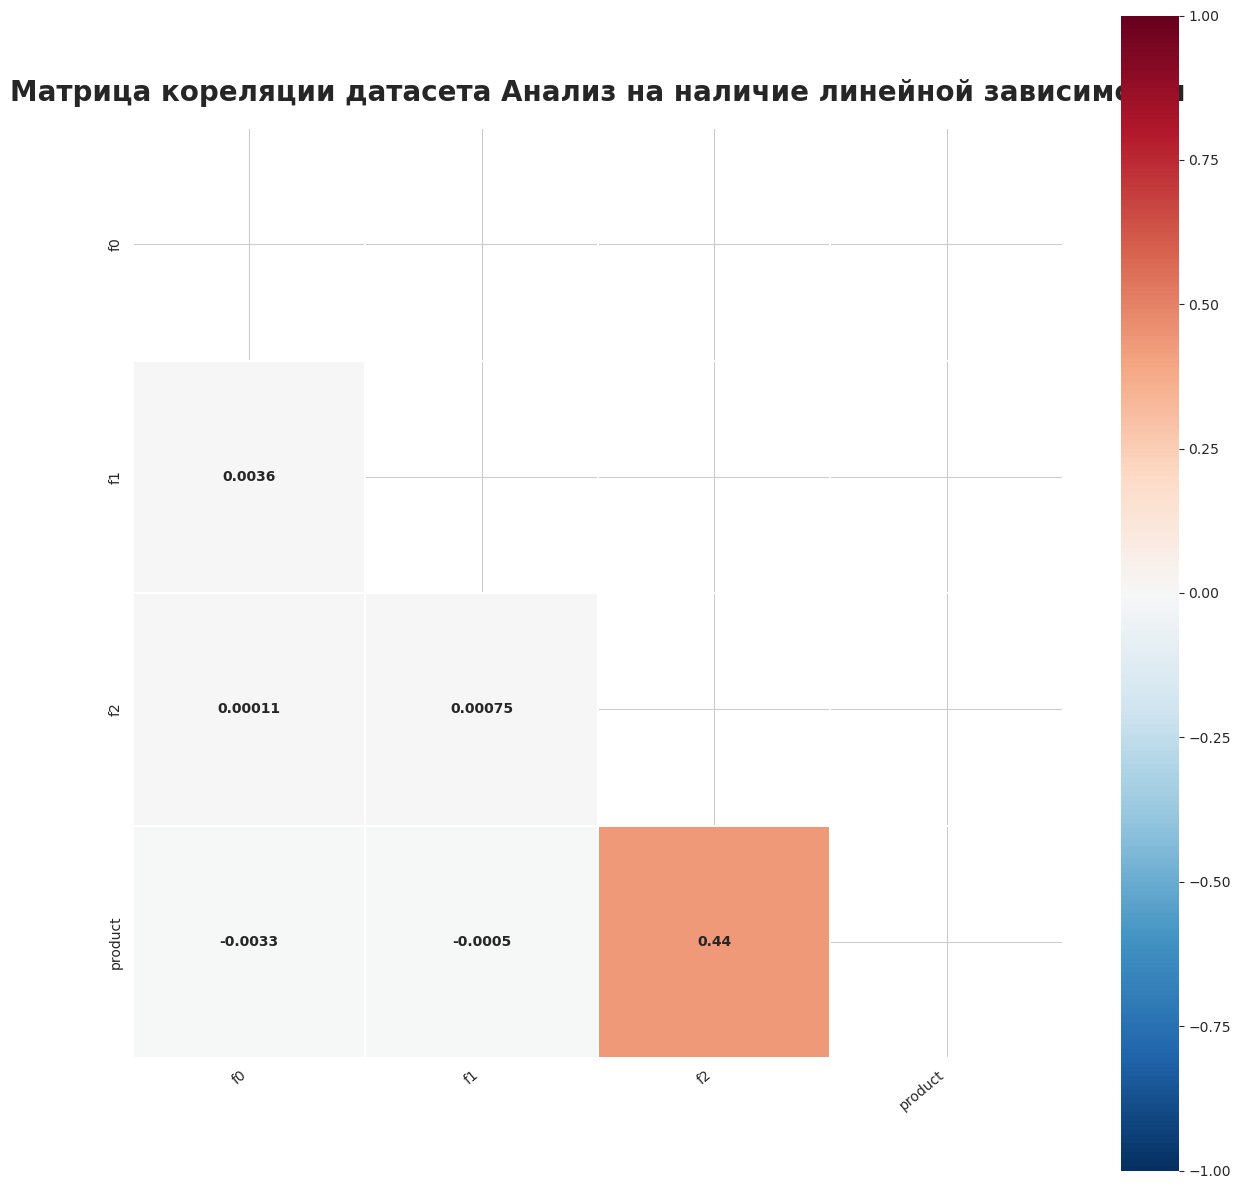

In [87]:
plot_corr_heatmap(geo_data_2.drop(columns={'id'}), "Анализ на наличие линейной зависимости")

**Промежуточные выводы**

Мультиколениарности нет

##### Выводы

Во время осмотра данных третего датасета, аномалий выявленно не было

#### Выводы по разделу

Мы загрузили и проанализировали данные, выявили и устранили недостатки, такие как наличие неявных дубликатов и мульиколениарность. Теперь мы готовы приступить ко второй части нашего проекта

## Обучение и проверка модели

Цель раздела: Построить модель для определения региона, где добыча принесёт наибольшую прибыль.


### geo_data_0

In [88]:
# Сформируем набор факторов учавствующих в моделировании
num_features = ['f0_transformed',
                'f1_transformed',
                'f2'
               ]



In [89]:
X0 = geo_data_0[num_features]
y0 = geo_data_0['product']

#### Подготовка датасетов Train, Test, Valid

In [90]:
# Разделим данные на 3 выборки в пропорциях
#training: 75%, testing: 25%, validation: 25%
#X0_train, X0_test_valid, y0_train, y0_test_valid = train_test_split(X0, y0, test_size=0.25, random_state=RANDOM_STATE)
#X0_test, X0_valid, y0_test, y0_valid = train_test_split(X0_test_valid, y0_test_valid, test_size=0.5, random_state=RANDOM_STATE)
X0_train, X0_valid, y0_train, y0_valid = train_test_split(X0, y0, test_size=0.25, random_state=RANDOM_STATE)

In [91]:
#print("X0_train:", X0_train.shape)
#print("X0_test:", X0_test.shape)
#print("X0_valid:", X0_valid.shape)
#print("y0_train:", y0_train.shape)
#print("y0_test:", y0_test.shape)
#print("y0_valid:", y0_valid.shape)

print("X0_train:", X0_train.shape)
print("X0_valid:", X0_valid.shape)
print("y0_train:", y0_train.shape)
print("y0_valid:", y0_valid.shape)

X0_train: (74429, 3)
X0_valid: (24810, 3)
y0_train: (74429,)
y0_valid: (24810,)


##### Проверка на разброс

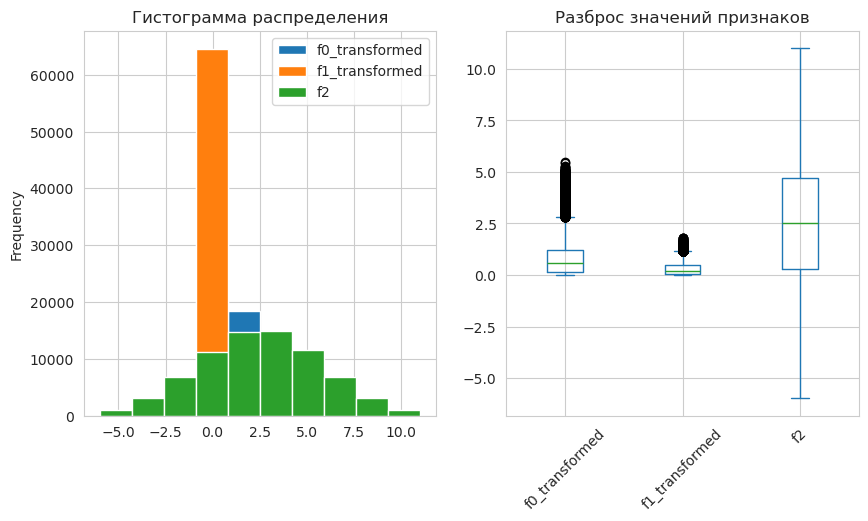

In [92]:
scaler_viz(X0_train)


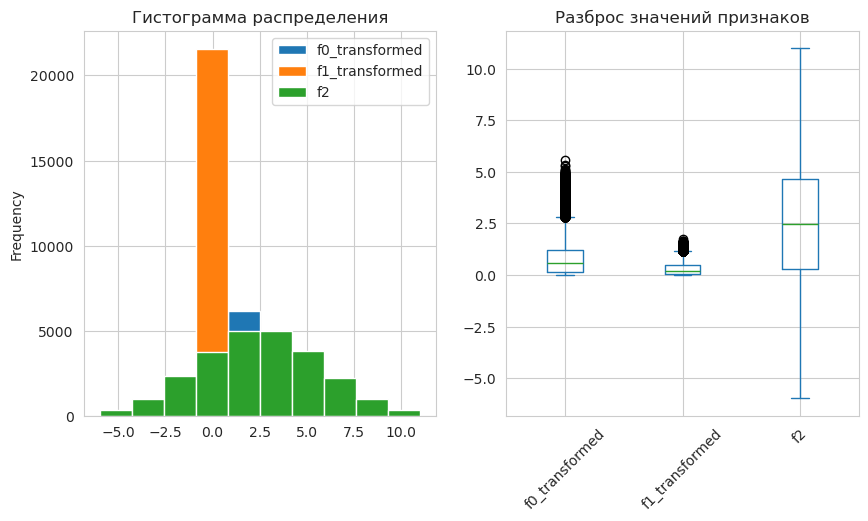

In [93]:
scaler_viz(X0_valid)

**Промежуточный вывод**

Вспомним, масштабирование стоит проводить для линейных, и метрических (KNN например, в этих моделях измеряют расстояния ).

По итогам проведенного анализа, можно сказать, что сильного разброса в числовых признаках не наблюдатеся, однако представленная картина не идеальна это значит что есть риски того, что веса модели будут некорректно отображать вклад каждого признака и что она начнёт считать важными признаки с высокими абсолютными значениями и будет занижать роль остальных.

Примем решение о целесообразности проведения масштабирования.

##### Маштабирование

In [94]:
scaler, X0s_train, X0s_valid = data_scaler(X0_train, X0_valid, scaler_type='MinMaxScaler')

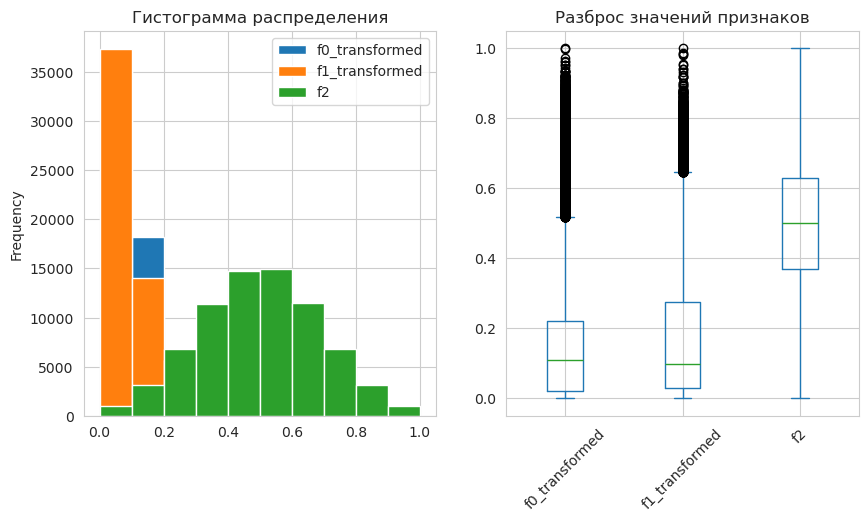

In [95]:
scaler_viz(X0s_train)

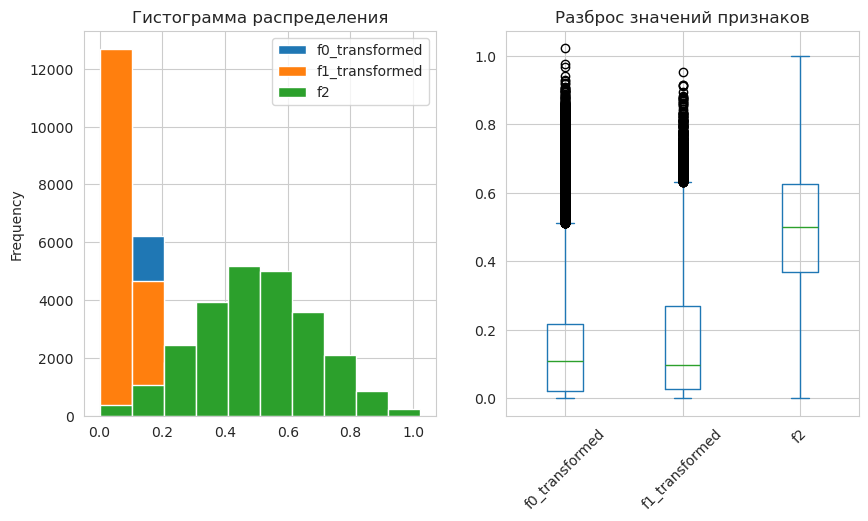

In [96]:
scaler_viz(X0s_valid)

**Промежуточный вывод**

Маштабирование прошло успешно, перейдем к следующему этапу

#### Моделирование

In [97]:
# Инициализируем модель линейной регрессии
model_lr0 = LinearRegression()

# Обучение модели линейной регрессии
model_lr0.fit(X0s_train, y0_train)

# Perform cross-validation
#fitted_model = cross_val_score(model_lr0, X0s_train, y0_train, cv=5)[1]

LinearRegression()

In [98]:
# сформируем предсказания на валидационной выборке
y0_valid_pred = model_lr0.predict(X0s_valid)

# Сохраним комбинацию фактического значения запасов и предсказанного
y0_true_pred = pd.DataFrame({'product_true': np.array(y0_valid),
                             'product_pred': y0_valid_pred.flatten()})

#### Анализ

In [99]:
# Рассчитаем RMSE и mean по региону
rmse_valid0 = round(mean_squared_error(y0_true_pred['product_true'], y0_true_pred['product_pred'], squared=False),2)
product_0_mean = round(y0_true_pred['product_pred'].mean(),2)

/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Анализ прогноза запасов сырья по всем скважинам в регионе geo_data_0


РАСЧЁТ средне-квадратичной ошибки прогнозов:
RMSE=38.3
Модель ошибается в среднем на 38.3 тыс. бар.

РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=92.53
В среднем по региону  geo_data_0  прогноз запасов нефети на одну скважину составляет 92.53 тыс. бар.


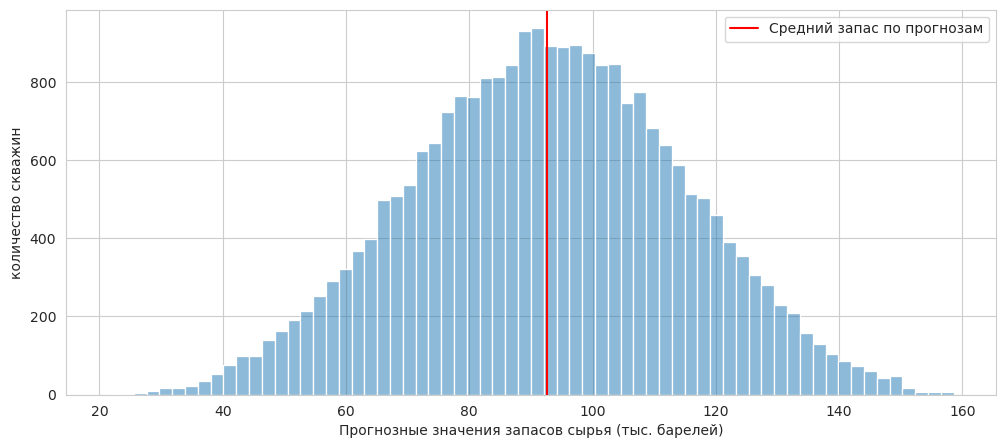

In [100]:
# Выведем информацию по расчетам
viz_prediction_prognozis(np.array(y0_true_pred['product_pred']), 
                         rmse_valid0, 
                         product_0_mean, 
                         'geo_data_0', 
                         'Анализ прогноза запасов сырья по всем скважинам в регионе geo_data_0')


In [101]:
# Выберем 200 лучших скважин и проведем расчет среднего среди выбранных
y0_valid_pred_top_200 =  y0_true_pred.sort_values(by='product_pred',ascending=False)[:200]
product_0_top_200_mean = round(y0_valid_pred_top_200.product_pred.mean(),2)

Анализ прогноза запасов сырья по скважинам ТОП-200 в регионе geo_data_0


РАСЧЁТ средне-квадратичной ошибки прогнозов:
RMSE=38.3
Модель ошибается в среднем на 38.3 тыс. бар.

РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=147.9
В среднем по региону  geo_data_0  прогноз запасов нефети на одну скважину составляет 147.9 тыс. бар.


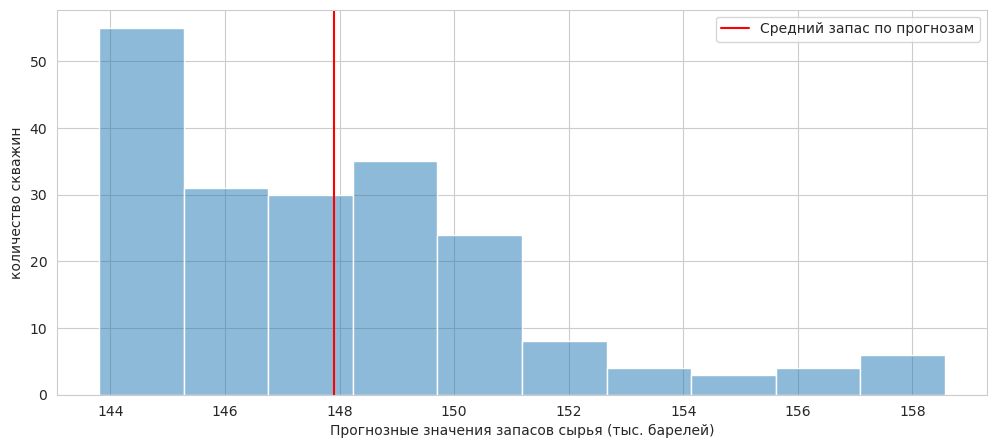

In [102]:
# Выведем информацию по расчетам
viz_prediction_prognozis(np.array(y0_valid_pred_top_200.product_pred), 
                         rmse_valid0, 
                         product_0_top_200_mean, 
                         'geo_data_0', 
                         'Анализ прогноза запасов сырья по скважинам ТОП-200 в регионе geo_data_0')


РАСЧЁТ R²(коэф. детерминации):
R²=0.25
Учтённые факторы на 25.0 процентов объясняют целевую


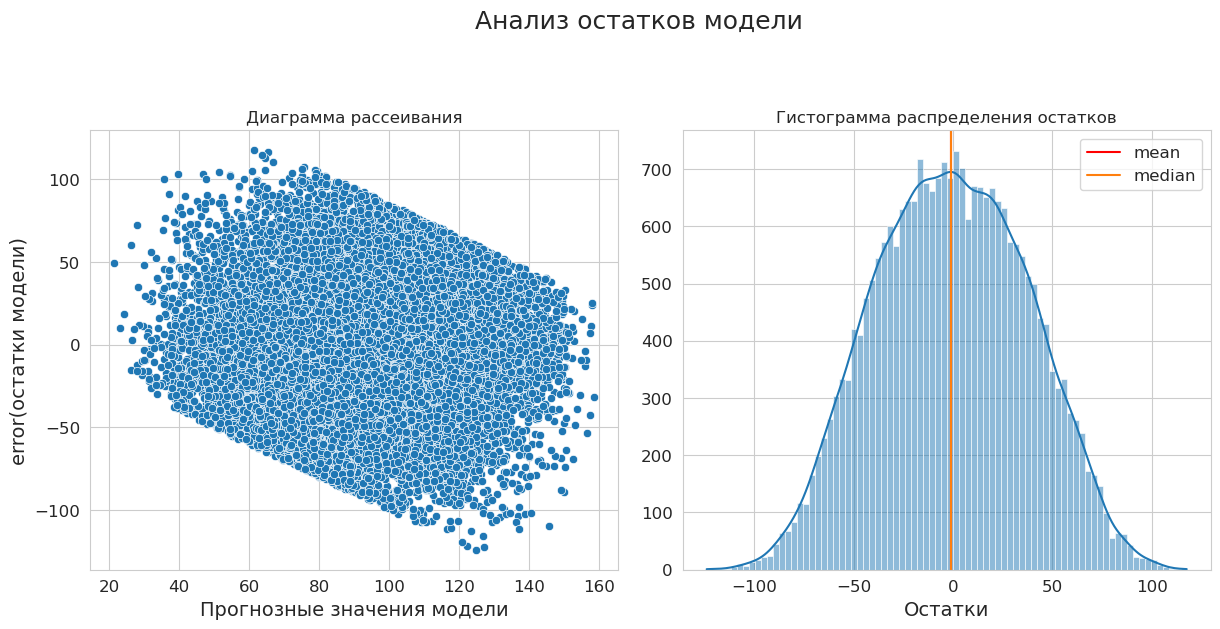

In [103]:
r_sqr_analysis(y0_valid, y0_valid_pred, 'product')

**Промежуточный вывод**

По результатм обучения нашей модели мы видим, что в среднем наша модель ошибается на 38.3 тыс. барелей, в то время как средний запас предсказанного сырья для нулевого региона составляет 92.5 тыс барелей.
При этом если взять выборку топ-200 прогнозных скважин, то средний доход составляет 147.9 тысяч барелей

### geo_data_1

In [104]:
geo_data_1.head(3)

id         f0        f1     product
0  kBEdx -15.001348 -8.276000    3.179103
1  62mP7  14.272088 -3.475083   26.953261
2  vyE1P   6.263187 -5.948386  134.766305

In [105]:
# Сформируем набор факторов учавствующих в моделировании
num_features = ['f0',
                'f1'
               ]

In [106]:
X1 = geo_data_1[num_features]
y1 = geo_data_1['product']

#### Подготовка датасетов

In [107]:
# Разделим данные на 3 выборки в пропорциях
#training: 75%, testing: 25%, validation: 25%
#X0_train, X0_test_valid, y0_train, y0_test_valid = train_test_split(X0, y0, test_size=0.25, random_state=RANDOM_STATE)
#X0_test, X0_valid, y0_test, y0_valid = train_test_split(X0_test_valid, y0_test_valid, test_size=0.5, random_state=RANDOM_STATE)
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1, y1, test_size=0.25, random_state=RANDOM_STATE)

In [108]:
#print("X1_train:", X1_train.shape)
#print("X1_test:", X1_test.shape)
#print("X1_valid:", X1_valid.shape)
#print("y1_train:", y1_train.shape)
#print("y1_test:", y1_test.shape)
#print("y1_valid:", y1_valid.shape)

print("X1_train:", X1_train.shape)
print("X1_valid:", X1_valid.shape)
print("y1_train:", y1_train.shape)
print("y1_valid:", y1_valid.shape)

X1_train: (74181, 2)
X1_valid: (24728, 2)
y1_train: (74181,)
y1_valid: (24728,)


##### Проверка на разброс

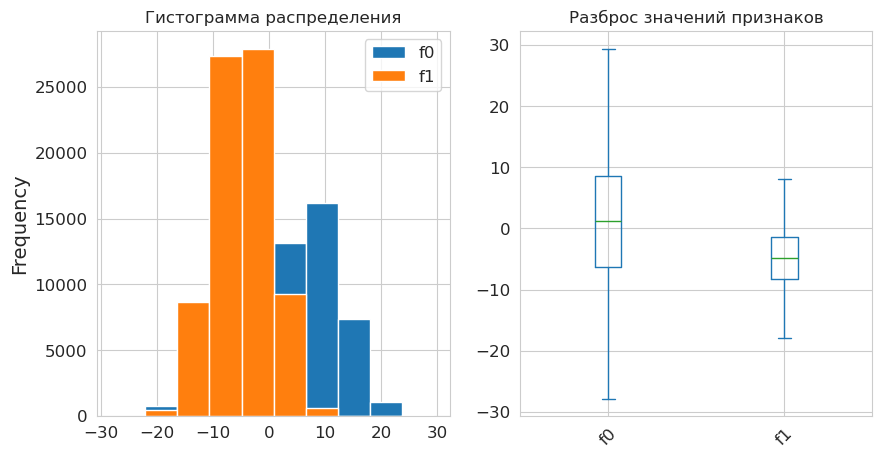

In [109]:
scaler_viz(X1_train)

**Промежуточный вывод**

Разброс выглядит приемлемо, маштабировать не будем

##### Маштабирование

#### Моделирование

In [110]:
# Инициализируем модель линейной регрессии
model_lr1 = LinearRegression()

# Обучение модели линейной регрессии
model_lr1.fit(X1_train, y1_train)

# Perform cross-validation
#fitted_model = cross_val_score(model_lr0, X0s_train, y0_train, cv=5)[1]

LinearRegression()

In [111]:
# сформируем предсказания на валидационной выборке
y1_valid_pred = model_lr1.predict(X1_valid)
# Сохраним комбинацию фактического значения запасов и предсказанного
y1_true_pred = pd.DataFrame({'product_true': np.array(y1_valid),
                             'product_pred': y1_valid_pred.flatten()})

#### Анализ

In [112]:
# Рассчитаем RMSE
rmse_valid1 = round(mean_squared_error(y1_true_pred['product_true'], y1_true_pred['product_pred'], squared=False),2)
product_1_mean = round(y1_true_pred['product_pred'].mean(),2)

/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_1


РАСЧЁТ средне-квадратичной ошибки прогнозов:
RMSE=45.83
Модель ошибается в среднем на 45.83 тыс. бар.

РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=68.85
В среднем по региону  geo_data_1  прогноз запасов нефети на одну скважину составляет 68.85 тыс. бар.


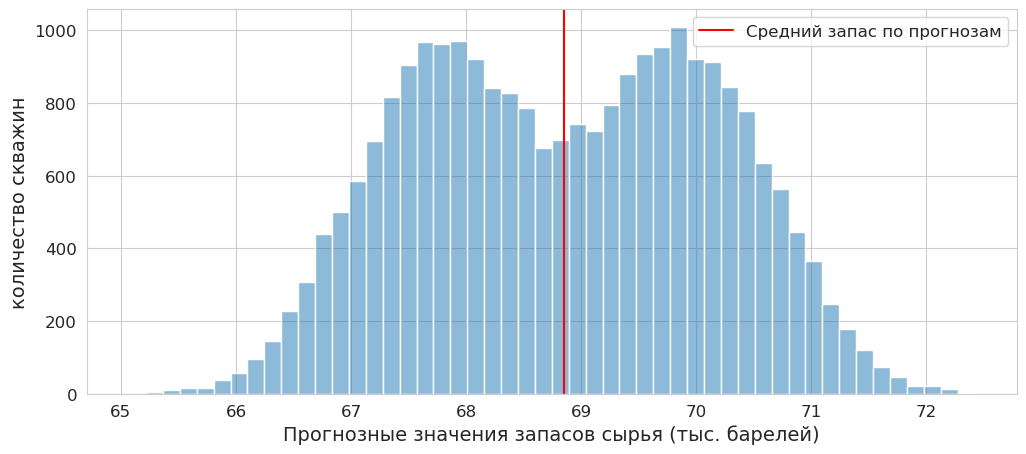

In [113]:
# Выведем информацию по расчетам
viz_prediction_prognozis(np.array(y1_true_pred['product_pred']), 
                         rmse_valid1, 
                         product_1_mean, 
                         'geo_data_1', 
                         'Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_1')


In [114]:
# Выберем топ 200 скважин с самыми высокими предсказаниями и расчитаем среднее
y1_valid_pred_top_200 = (np.sort(y1_valid_pred,axis=0)[::-1])[:200]
y1_valid_pred_top_200 = y1_true_pred.sort_values(by='product_pred',ascending=False)[:200]
product_1_top_200_mean = round(y1_valid_pred_top_200.product_pred.mean(),2)

Анализ прогноза запасов сырья по скважинам ТОП-200 в регионе geo_data_1


РАСЧЁТ средне-квадратичной ошибки прогнозов:
RMSE=45.83
Модель ошибается в среднем на 45.83 тыс. бар.

РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=71.77
В среднем по региону  geo_data_1  прогноз запасов нефети на одну скважину составляет 71.77 тыс. бар.


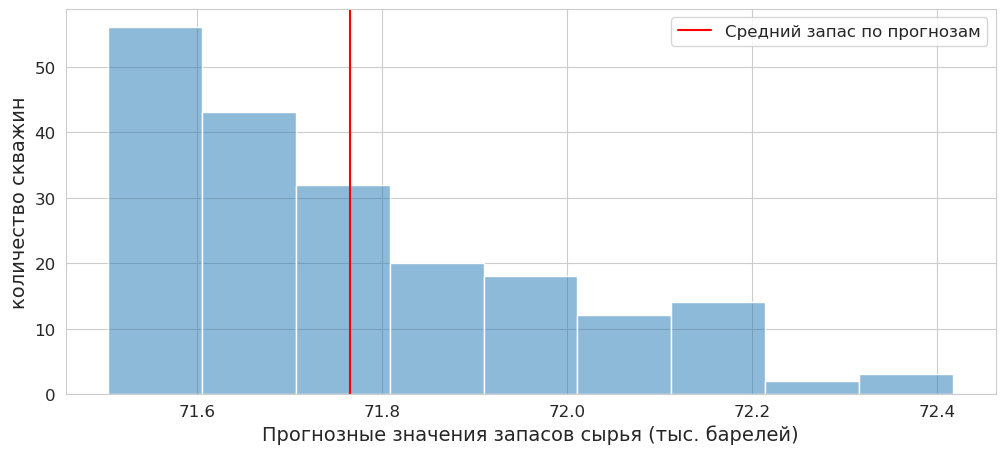

In [115]:
# Выведем информацию по расчетам
viz_prediction_prognozis(np.array(y1_valid_pred_top_200.product_pred), 
                         rmse_valid1, 
                         product_1_top_200_mean, 
                         'geo_data_1', 
                         'Анализ прогноза запасов сырья по скважинам ТОП-200 в регионе geo_data_1')


**Промежуточный вывод**

По результатм обучения нашей модели мы видим, что в среднем наша модель ошибается на 45.8 тыс. барелей, в то время как средний запас предсказанного сырья для первого региона составляет 68.8 тыс барелей.

Средний прогноз добычи по топ-20 скважинам, составляет 71.77 тыс барелей

### geo_data_2

In [116]:
geo_data_2.head(3)

id        f0        f1        f2    product
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673
1  WJtFt  0.262778  0.269839 -2.530187  56.069697
2  ovLUW  0.194587  0.289035 -5.586433  62.871910

In [117]:
# Сформируем набор факторов учавствующих в моделировании
num_features = ['f0',
                'f1',
                'f2'
               ]


In [118]:
X2 = geo_data_2[num_features]
y2 = geo_data_2['product']

#### Подготовка датасетов

In [119]:
# Разделим данные на 3 выборки в пропорциях
#training: 75%, testing: 25%, validation: 25%
#X0_train, X0_test_valid, y0_train, y0_test_valid = train_test_split(X0, y0, test_size=0.25, random_state=RANDOM_STATE)
#X0_test, X0_valid, y0_test, y0_valid = train_test_split(X0_test_valid, y0_test_valid, test_size=0.5, random_state=RANDOM_STATE)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.25, random_state=RANDOM_STATE)

In [120]:
#print("X2_train:", X2_train.shape)
#print("X2_test:", X2_test.shape)
#print("X2_valid:", X2_valid.shape)
#print("y2_train:", y2_train.shape)
#print("y2_test:", y2_test.shape)
#print("y2_valid:", y2_valid.shape)

print("X2_train:", X2_train.shape)
print("X2_valid:", X2_valid.shape)
print("y2_train:", y2_train.shape)
print("y2_valid:", y2_valid.shape)

X2_train: (70930, 3)
X2_valid: (23644, 3)
y2_train: (70930,)
y2_valid: (23644,)


##### Проверка на разброс

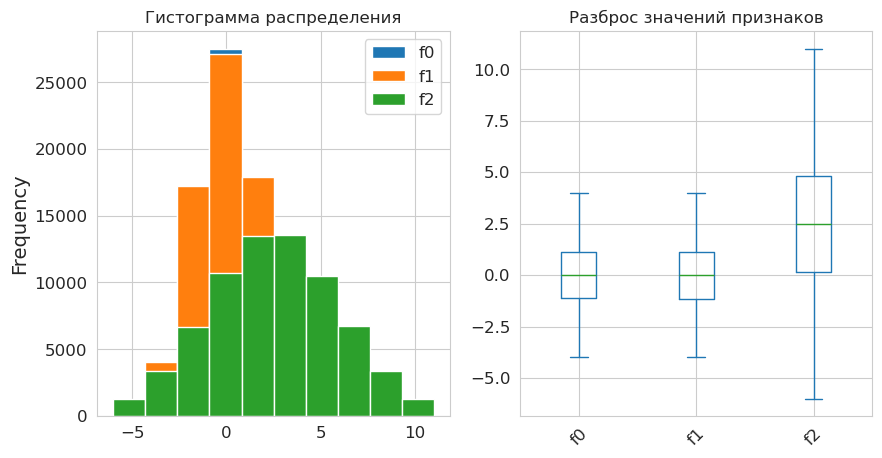

In [121]:
scaler_viz(X2_train)

**Промежуточный вывод**

Разброс выглядит приемлемо, маштабировать не будем

##### Маштабирование

#### Моделирование

In [122]:
# Инициализируем модель линейной регрессии
model_lr2 = LinearRegression()

# Обучение модели линейной регрессии
model_lr2.fit(X2_train, y2_train)

# Perform cross-validation
#fitted_model = cross_val_score(model_lr0, X0s_train, y0_train, cv=5)[1]

LinearRegression()

In [123]:
# сформируем предсказания на валидационной выборке
y2_valid_pred = model_lr2.predict(X2_valid)
# Сохраним комбинацию фактического значения запасов и предсказанного
y2_true_pred = pd.DataFrame({'product_true': y2_valid,
                             'product_pred': y2_valid_pred.flatten()})

#### Анализ

In [124]:
# Рассчитаем RMSE
rmse_valid2 = round(mean_squared_error(y2_true_pred.product_true, y2_true_pred.product_pred, squared=False),2)
product_2_mean = round(y2_true_pred.product_pred.mean(),2)

/home/zai11972/miniconda3/envs/gpt_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Анализ прогноза запасов сырья по всем скважинам в регионе geo_data_2


РАСЧЁТ средне-квадратичной ошибки прогнозов:
RMSE=40.15
Модель ошибается в среднем на 40.15 тыс. бар.

РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=94.43
В среднем по региону  geo_data_2  прогноз запасов нефети на одну скважину составляет 94.43 тыс. бар.


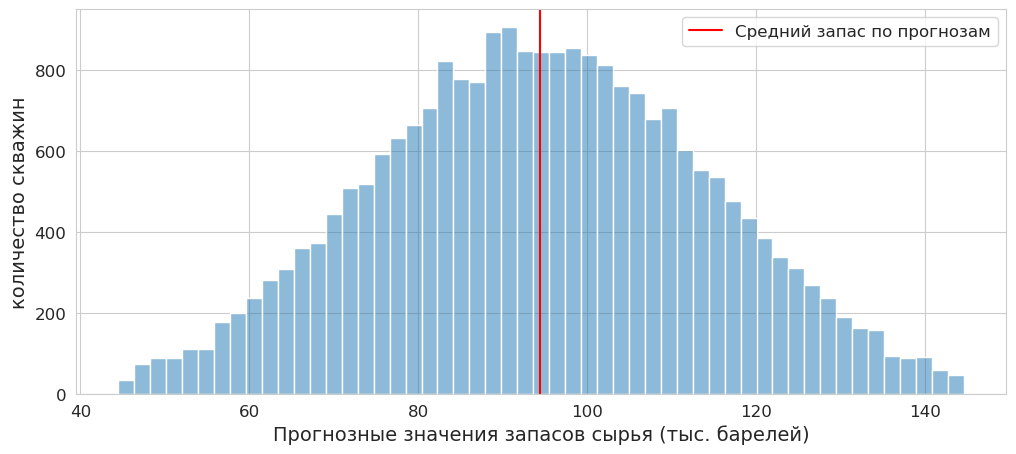

In [125]:
# Выведем информацию по расчетам
viz_prediction_prognozis(np.array(y2_true_pred.product_pred), 
                         rmse_valid2, 
                         product_2_mean, 
                         'geo_data_2', 
                         'Анализ прогноза запасов сырья по всем скважинам в регионе geo_data_2')


In [126]:
# Выберем топ 200 скважин по предсказаниям и расчитаем среднее
#y2_valid_pred_top_200 = (np.sort(y2_valid_pred,axis=0)[::-1])[:200]
y2_valid_pred_top_200 = y2_true_pred.sort_values(by='product_pred',ascending=False)[:200]
product_2_top_200_mean = round(y2_valid_pred_top_200.product_pred.mean())

Анализ прогноза запасов сырья по скважинам ТОП-200 в регионе geo_data_2


РАСЧЁТ средне-квадратичной ошибки прогнозов:
RMSE=40.15
Модель ошибается в среднем на 40.15 тыс. бар.

РАСЧЁТ ПРОГНОЗА СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=141
В среднем по региону  geo_data_2  прогноз запасов нефети на одну скважину составляет 141 тыс. бар.


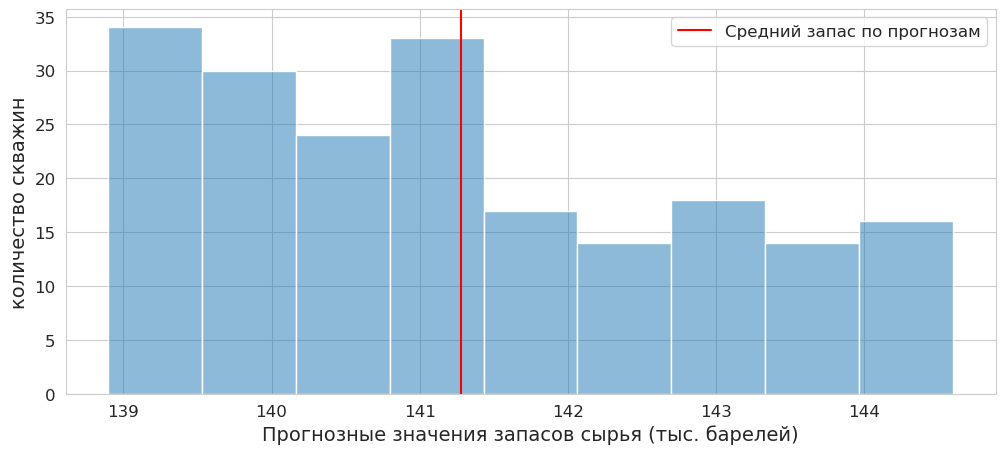

In [127]:
# Выведем информацию по расчетам
viz_prediction_prognozis(np.array(y2_valid_pred_top_200.product_pred), 
                         rmse_valid2, 
                         product_2_top_200_mean, 
                         'geo_data_2', 
                         'Анализ прогноза запасов сырья по скважинам ТОП-200 в регионе geo_data_2')


## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе составляет 10 млрд. рублей. Доход с каждой единцы продукта составляет 450 тыс. рублей, исходя из того, что одной единеницей продукта ялвяется тысяча барелей, где цена за 1 барель равна 450 рублей. Из условий проекта так же известно, что в выбранном регионе будет разрабатываться 200 наиболее персперктивных скважин. 


In [128]:
# Входные данные
# Бюджет проекта
project_budget = 10000000000
# Количество скважин для расчетов
nwels = 500 
# Количество лучших скважин для проекта
ntop_wels= 200
# Доход с единцы продукат(1 тыс барелей)
return_per_barrel = 450000

# Расчеты
# Минимальное среднее кол-во барелей с одной скважины для безубыточной разработки проекта
avg_minimum_barels_per_well = round((project_budget / ntop_wels)  / return_per_barrel,2)
# Минимальный запас нефти по региону необходимый для окупаемости проекта
avg_barrels_per_region = round(project_budget / return_per_barrel,2)

Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_0


РАСЧЁТ ФАКТИЧЕСКОГО СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=92.53
В среднем по региону  geo_data_0  фактический запас нефети на одну скважину составляет 92.53 тыс. бар.


МИНИМАЛЬНЫЙ ЗАПАС НЕФТИ НА СКВАЖИНУ НЕОБХОДИМЫЙ ДЛЯ ОКУПАЕМОСТИ ПРОЕКТА:
mean=111.11


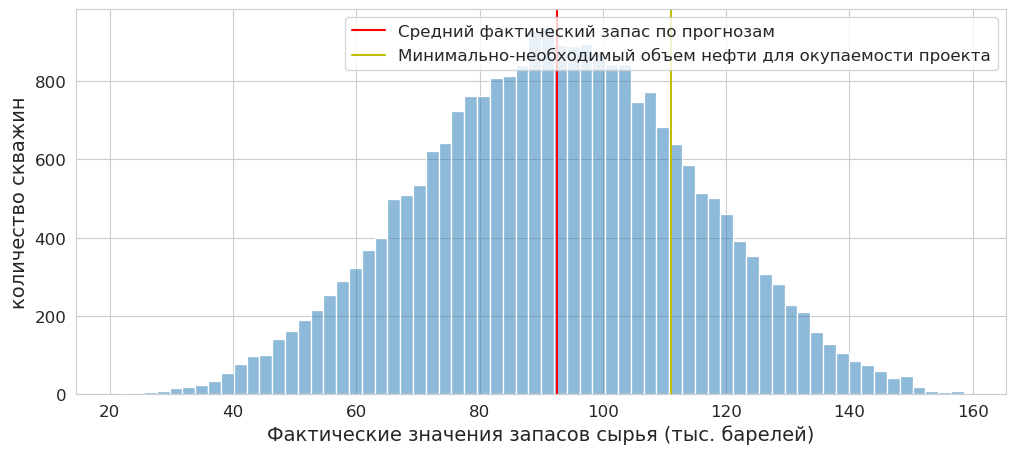

In [129]:
# Выведем фактическим запасм в регионе 0
viz_analysis_fact(np.array(y0_true_pred['product_pred']), 
                           product_0_mean, 
                           'geo_data_0', 
                           'Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_0',
                           avg_minimum_barels_per_well)

Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_1


РАСЧЁТ ФАКТИЧЕСКОГО СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=68.85
В среднем по региону  geo_data_1  фактический запас нефети на одну скважину составляет 68.85 тыс. бар.


МИНИМАЛЬНЫЙ ЗАПАС НЕФТИ НА СКВАЖИНУ НЕОБХОДИМЫЙ ДЛЯ ОКУПАЕМОСТИ ПРОЕКТА:
mean=111.11


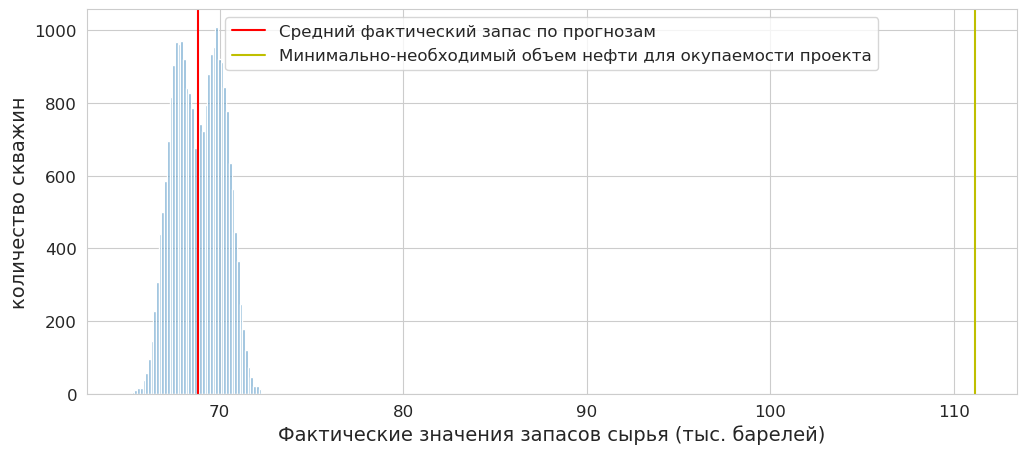

In [130]:
viz_analysis_fact(np.array(y1_true_pred['product_pred']), 
                           product_1_mean, 
                           'geo_data_1', 
                           'Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_1',
                            avg_minimum_barels_per_well)

Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_2


РАСЧЁТ ФАКТИЧЕСКОГО СРЕДНЕГО ЗАПАСА СЫРЬЯ:
mean=94.43
В среднем по региону  geo_data_2  фактический запас нефети на одну скважину составляет 94.43 тыс. бар.


МИНИМАЛЬНЫЙ ЗАПАС НЕФТИ НА СКВАЖИНУ НЕОБХОДИМЫЙ ДЛЯ ОКУПАЕМОСТИ ПРОЕКТА:
mean=111.11


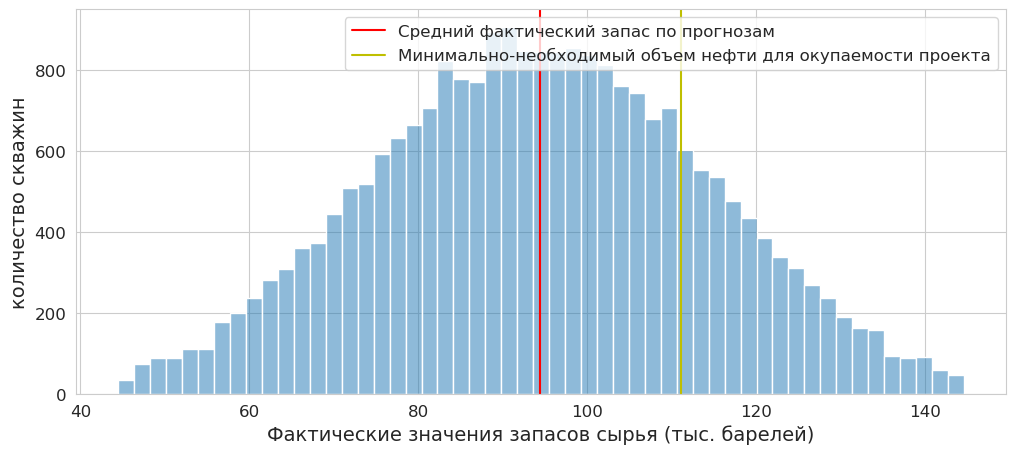

In [131]:
viz_analysis_fact(np.array(y2_true_pred['product_pred']), 
                           product_2_mean, 
                           'geo_data_2', 
                           'Анализ прогноза запасов сырья по всем кважинам в регионе geo_data_2',
                           avg_minimum_barels_per_well)

**Промежуточный вывод**

Мы расчитали, что для окупаемости проекта стоимостью 10 млрд рублей на 200 скважин, минимальный запас нефти в каждой из двухста выбранных скважин должен сотавлять не менее 111.11 единиц продукта.

Исходя из полученных графиков и данных, можно с уверенностью заключить, что регон 1 можно сразу отсекать, так как уже сейчас видно что разведанных запасов нефти недостаточно для условий окупаемости проекта. А вот регионы 0 и 2 выглядят вполне перспективно.

## Расчёт прибыли и рисков 

In [132]:
def get_bootstrap(df):
    state = np.random.RandomState(RANDOM_STATE)
    loses = 0
    # сохраните значения 99%-квантилей в переменной values
    values = []
    for i in range(1000):
        #  Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
        preds_subsample = df.sample(replace=True, 
                                    random_state=state, 
                                    n=nwels)

        subsample_true_product_sum = preds_subsample.sort_values(by='product_pred',ascending=False)[:ntop_wels].product_true.sum()
        profit_est = (return_per_barrel * subsample_true_product_sum) - project_budget

        if profit_est < 0:
            loses +=1

        values.append(profit_est)

    values = pd.Series(values)
    
    return loses, values
    

In [133]:
# Функция для расчета прибыли по выбранным скважинам
def profit_calc(df):
    profit = lambda x: round((x * return_per_barrel),2)    
    
    df['profit_true'] = profit(df.product_true)
    df['profit_pred'] = profit(df.product_pred)
    
    return df

In [134]:
# Расчитаем выручку по фактическим и предсказанным запасам в разрезе каждого региона
y0_true_pred = profit_calc(y0_true_pred)
y1_true_pred = profit_calc(y1_true_pred)
y2_true_pred = profit_calc(y2_true_pred)

### geo_data_0

In [135]:
# Просуммируем целевое значение объёма сырья, соответствующее предсказаниям.
y0_pred_product_sum = y0_true_pred.sort_values(by='product_pred',ascending=False)[:ntop_wels].product_pred.sum()
print(f'Сумарное целевое значение объема сырья по предсказаниям для региона geo_data_0: {round(y0_pred_product_sum,2)} тыс. барелей')


Сумарное целевое значение объема сырья по предсказаниям для региона geo_data_0: 29580.59 тыс. барелей


In [136]:
# Расчет прибыли для полученного объема сырья
y0_pred_profit_sum = y0_true_pred.sort_values(by='product_pred',ascending=False)[:ntop_wels].profit_pred.sum() /1000
print(f'Для региона geo_data_0, сумарный прогноз прибыли для объема сырья: {round((y0_pred_product_sum ),2)} (в тыс.бар) по предсказаниям составит: {round(y0_pred_profit_sum,2)} (в тыс. р.)')


Для региона geo_data_0, сумарный прогноз прибыли для объема сырья: 29580.59 (в тыс.бар) по предсказаниям составит: 13311264.76 (в тыс. р.)


### geo_data_1

In [137]:
# Просуммируем целевое значение объёма сырья, соответствующее предсказаниям.
y1_pred_product_sum = y1_true_pred.sort_values(by='product_pred',ascending=False)[:ntop_wels].product_pred.sum()
print(f'Сумарное целевое значение объема сырья по предсказаниям для региона geo_data_1: {round(y1_pred_product_sum,2)} тыс. барелей')


Сумарное целевое значение объема сырья по предсказаниям для региона geo_data_1: 14353.09 тыс. барелей


In [138]:
# Расчет прибыли для полученного объема сырья
y1_pred_profit_sum = y1_true_pred.sort_values(by='product_pred',ascending=False)[:ntop_wels].profit_pred.sum() /1000
print(f'Для региона geo_data_1, сумарный прогноз прибыли для объема сырья: {round((y1_pred_product_sum ),2)} (в тыс.бар) по предсказаниям составит: {round(y1_pred_profit_sum,2)} (в тыс. р.)')


Для региона geo_data_1, сумарный прогноз прибыли для объема сырья: 14353.09 (в тыс.бар) по предсказаниям составит: 6458892.12 (в тыс. р.)


### geo_data_2

In [139]:
# Просуммируем целевое значение объёма сырья, соответствующее предсказаниям.
y2_pred_product_sum = y2_true_pred.sort_values(by='product_pred',ascending=False)[:ntop_wels].product_pred.sum()
print(f'Сумарное целевое значение объема сырья по предсказаниям для региона geo_data_2: {round(y2_pred_product_sum,2)} тыс. барелей')


Сумарное целевое значение объема сырья по предсказаниям для региона geo_data_2: 28255.58 тыс. барелей


In [140]:
# Расчет прибыли для полученного объема сырья
y2_pred_profit_sum = y2_true_pred.sort_values(by='product_pred',ascending=False)[:ntop_wels].profit_pred.sum() /1000
print(f'Для региона geo_data_2, сумарный прогноз прибыли для объема сырья: {round((y2_pred_product_sum ),2)} (в тыс.бар) по предсказаниям составит: {round(y2_pred_profit_sum,2)} (в тыс. р.)')


Для региона geo_data_2, сумарный прогноз прибыли для объема сырья: 28255.58 (в тыс.бар) по предсказаниям составит: 12715013.25 (в тыс. р.)


**Промежуточный вывод**

Прогнозы по регионам на топ-200 скважин:
 - geo_data_0:
  - 29580.59 (в тыс.бар): 13.3 миллиарда рублей
 - geo_data_1:
  - 14353.09 (в тыс.бар): 6.4 миллиарда рублей
 - geo_data_2:
  - 28255.58 (в тыс.бар): 12.7 миллиарда рублей
  
Пока самым перспективным выходит регон 0, прибыль с проекта составит 3.3 миллиарда рублей

### Bootstrap с 1000 выборок

#### geo_data_0

In [141]:
loses, values =  get_bootstrap(y0_true_pred)

print(f'Средняя прибыль: {round(values.mean(),2)}')
print(f'95% доверительный интервал от {round(values.quantile(0.025),2)} до {round(values.quantile(0.975),2)}' )
print(f'Процент риска:  {(loses * 100)/ 1000} %')

Средняя прибыль: 275121379.62
95% доверительный интервал от -210210851.12 до 777753453.1
Процент риска:  13.4 %


#### geo_data_1

In [142]:
loses, values =  get_bootstrap(y1_true_pred)

print(f'Средняя прибыль: {values.mean()}')
print(f'95% доверительный интервал от {values.quantile(0.025)} до {values.quantile(0.975)}' )
print(f'Процент риска: {(loses * 100)/ 1000} %')

Средняя прибыль: -3637240389.024974
95% доверительный интервал от -4202353552.1158133 до -3083555823.277061
Процент риска: 100.0 %


#### geo_data_2

In [143]:
loses, values =  get_bootstrap(y2_true_pred)

print(f'Средняя прибыль: {values.mean()}')
print(f'95% доверительный интервал от {values.quantile(0.025)} до {values.quantile(0.975)}' )
print(f'Процент риска: {(loses * 100)/ 1000} %')

Средняя прибыль: 243394291.26899445
95% доверительный интервал от -292983948.8407336 до 774680743.9797249
Процент риска: 18.6 %


### Вывод

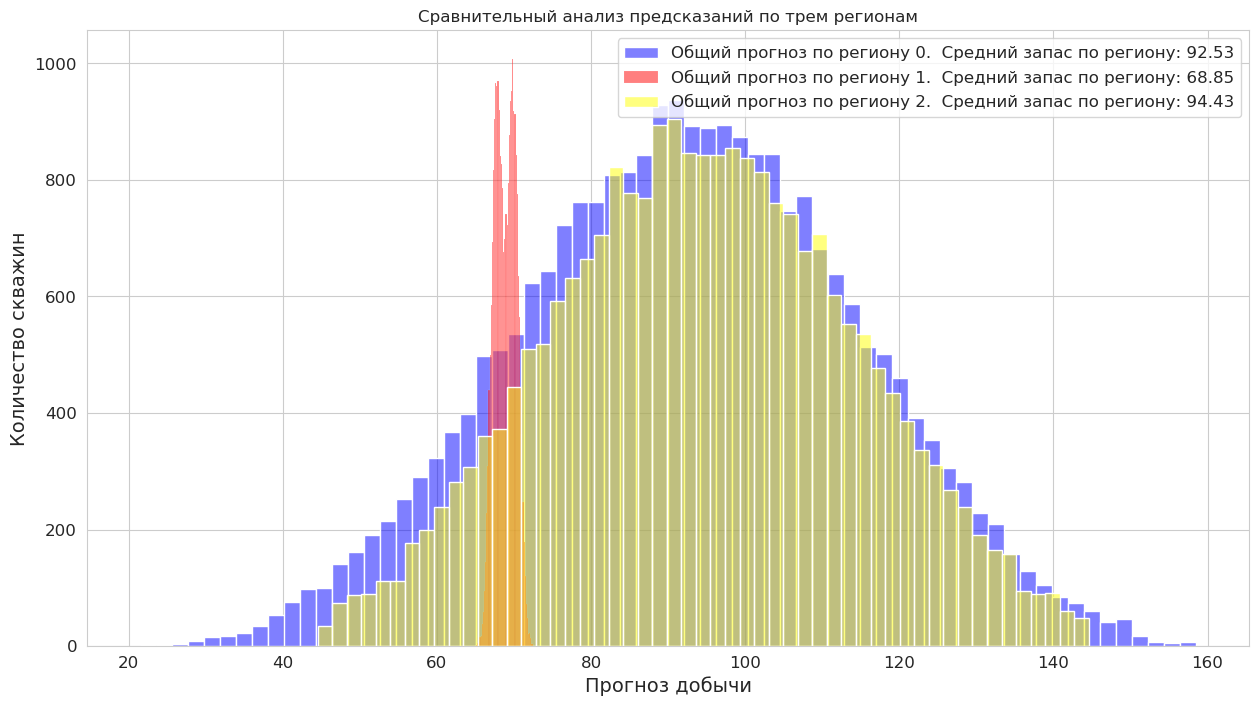

In [144]:
plot_summary_alaysis(np.array(y0_true_pred.product_pred),  np.array(y1_true_pred.product_pred),  np.array(y2_true_pred.product_pred), 
                     product_0_mean, product_1_mean, product_2_mean)

**Вывод**

Для безубыточной добычи сырья проекту требуется получать не менее 111 единиц сырья с одной скважины. Исходя из этих требований в сравнеии со средним запасом по региону, для целей проекта подходят регионы 0 и 2. Так же на текущем этапе, мы с уверенностью можем заключить, что регион 1 не удовлетворяет параметрам проекта, так как уже сейчас видно что запасов недостаточно, кроме того он в 100% зоне риска.
Значит остаютс регионы 0 и 2, из данных двух регионов мы рекомендуем присмотрется к региону geo_data_0, так как здесь возможно получение максимальной прибыли